# Automatic Well-Log Depth Matching with Machine Learning

* __Author__: _Wen Pan (tutorial and competition setup), Michael Ashby (Challenge design and data preparation), Hyungjoo Lee (Review), Lei Fu (Review), Yanxiang Yu (Review), Jaehyuk Lee (Review)_
* __Date__: Feburary 18th, 2023

- <a>1. Introduction </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models for Well-Log Prediction</a>
- <a>7. Build DTW-Based Well-Log Alignment Model</a>
- <a>8. Prediction</a>
- <a>9. Discussion</a>
- <a>10. Summary</a>

<a></a>

## Abstract

Well-log preprocessing is important for the accurate interpretation of well logs in the oil and gas industry. Well-log preprocessing usually involves well-log visualization, well-log QC and editing, , depth shifting for well logs and core data, and environment correction. Depth matching is one of the most time-consuming steps in well-log preprocessing that requires a lot of efforts from petrophysicists. Therefore, we see great opportunity for the application of machine learning methods to automate the depth shift process.

Common automatic depth shifting methods include cross-correlation method, dynamic time warping (DTW) method, reinforcement learning, convolutional neural network (CNN)-based method. In this tutorial, we demonstrate a model combining DTW and machine-learning method to perform depth shifting based on a gamma ray (GR) well log. This tutorial aims to provide a starting point for the participants of the 2023 Machine Learning Contest organized by the Society of Petrophysicists and Well Log Analysts (SPWLA) Petrophysical Data-Driven Analytics Special Interest Group (PDDA-SIG). In this tutorial we apply the Random Forest (RF) regression method to sequentially predict misaligned well logs (resistivity (RD), bulk density (RHOB), and neutron porosity (NPHI) logs) based on the reference GR log and aligned well logs. The RF model is trained and validate with well logs from nine aligned wells, and applied on the hidden misaligned well logs from four wells in the same field. DTW is applied to align misaligned well logs to the RF model prediction. The solutions submitted by participants will be ranked based on the rank transformation of the averaged root-mean-squared-error (RMSE) and mean absolute deviation (MAD) between the expert-aligned well logs and shifted well logs in the data set.

## <a>1. Introduction</a>

### <a>1.1. Background</a>
Well-log depth matching is the process of aligning the depths of misaligned well logs to the same reference depth. When logging tools are run in sequence, differences always occur in depth from tool to tool and from run to run. Even when the logging tools are run in a single string there are potential depth differences due to differential cable stretch. Stretch can be pronounced when the logging tool string sticks or temporally hangs up in the hole. All logging measurements must be adjusted to a common depth reference before data processing can continue. A depth shift of length 3 ft can destroy an otherwise good correlation among logging measurements or between well logs and cores.

All depths should be referenced to what is termed a base log. The base log is selected from a logging tool where strong or forceful tool positioning is not used. Free-moving tools travel through the borehole more smoothly than tools that are pushed with great force against the borehole wall, such as the density log. For this reason, strongly centralized tools are not selected as the base log. A resistivity log (induction or laterolog) is usually selected as the base log. For example, if gamma ray logs are available from both the density tool and induction tool strings, it is wise to select the gamma ray from the induction tool as the base log. The gamma ray from the density curve and all curves recorded with the density are then shifted to match the induction log depths. The base curve should also be selected based upon its expected strong correlation with the curves to be depth matched.
Depth-shifting programs are commonly of two types: (a) automatic depth-shifting programs in which mathematical correlations are made among curves from different tool strings and the shifting is accomplished without user input, or (b) visual correlation programs in which the curves to be shifted are laid beside or on top of the base curve, allowing the user to instruct the program by noting correlative points on each log and calculating the depth offset. With older programs, the correlations can be made by using log prints and the shifts input to the screen or a file. Most programs allow the user to carry or cause the same shift to be performed on other curves recorded on the same tool. (https://wiki.aapg.org/Preprocessing_of_logging_data)

### <a>1.2. Problem Statement</a>
The objective of this contest is to develop a data-driven model to shift misaligned well logs to a reference GR log. Well logs of nine wells from the same field that have been depth shifted by a petrophysicist. Participants' models will be trained/validated with these nine wells and tested on misaligned well logs from other three wells from the same field.

The submission should include the shifted well logs and the shifted depths

### <a>1.3. Data Description</a>
#### Files
#### ./data/train/aligned_well_*.csv
Training data for each well. Well logs are aligned by a senior petrophysicist. You need to augment the data in order to train the model. A simple data augmentation method is provided in this tutorial.
Varibles:
- DEPT - Depth, unit in feet
- GR - **Reference Gamma Ray**, unit in API
- RHOB - **Aligned Density Log**, unit in Gram per cubic centimeter
- NPHI - **Aligned Neutron Porosity**, unit in dec
- RD - **Aligned Deep Resistivity**, unit in Ohm.m


#### ./data/test/aligned_well_*.csv
The test data has all features in the train dataset, but they are not aligned (raw), you will need to predict the corrected well logs and associated depth shift.

Predictor Varibles:
- DEPT - Depth, unit in feet
- GR - **Reference Gamma Ray**, unit in API
- RHOB - **Raw Density Log**, unit in Gram per cubic centimeter
- NPHI - **Raw Neutron Porosity**, unit in dec
- RD - **Raw Deep Resistivity**, unit in Ohm.m

Target Variables:
- RHOB_pred - **Corrected Density Log**, unit in Gram per cubic centimeter
- NPHI_pred - **Corrected Neutron Porosity**, unit in dec
- RD_pred - **Corrected Deep Resistivity**, unit in Ohm.m
- RHOB_dept_pred - **Prediction of the Actual Depth of Raw Density Log**, unit in feet
- NPHI_dept_pred - **Prediction of the Actual Depth of Raw Neutron Porosity**, unit in feet
- RD_dept_pred - **Prediction of the Actual Depth of Raw Deep Resistivity**, unit in feet


####  ./data/pdda_submission_1.zip
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
Submissions are evaluated based on normalized mean squared error(NMSE) of corrected well logs and mean absolute deviation (MAD) of depth shift prediction, the final score will be rank transformed and averaged to avoid the scaling of different metrics. 

$$NMSE = \frac{1}{mn}\frac{1}{Var(\mathbf{y})}\sum_{i=1}^{m}\sum_{j=1}^{n}(\hat{\mathbf{y_{i,j}}} - \mathbf{y_{i,j}})^{2}$$

where
- $\hat{y_{i,j}}$ the prediction (RHOB_pred, NPHI_pred, RD_pred) of the **values** for shifted well log j, sample i. $y_{i,j}$ is the actual **values** of the well log j for sample i shifted by a petrophysicist. 
- $m$ is the sample size.
- $n$ is the number of well logs (RHOB, NPHI, RD): 3.
- $Var$ is the variance.

$$MAD = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}|\hat{\mathbf{d_{i,j}}} - \mathbf{d_{i,j}}| $$

where
- $\hat{d_{i,j}}$ is the prediction (RHOB_dept_pred, NPHI_dept_pred, RD_dept_pred) of **depth shift** for raw well log j, sample i. $d_{i,j}$ is the actual **depth shift of raw well logs** by a petrophysicist. 
- $m$ is the sample size.
- $n$ is the number of well logs (RHOB, NPHI, RD): 3.




**Note**:
- Please remember to use random_state for all randomization steps, so the results are reproducible.
- RD is transformed with log10 for RMSE calculation.
- The two scores for your prediction of different well logs will be rank transformed, and averaged, e.g., if the **NMSE** of predictions for the values of RHOB, NPHI, and RD ranks 1st, and the **MAD** of assosiated depth shifts ranks 3rd, your final score would be  $$score = \frac{1+3}{2}=2 $$ The team with the minimum score win the competition
- Understanding and optimizing your predictions for this evaluation metric is paramount for this competition.


**Notes for submission:**
1. Only one user can register for the competition per team. 
2. __The user name has to be exactly the same as the team name__. If space is not allowed, please replace space with underscore '_'.
3. The submission file must be a zip file with three .csv files, which include your predictions of corrected/shfited well logs and their depth shift. **Note: the three csv files in your submission should have the same file names as the three files in the test set**, see name convention below.
- Zipped csv file name {team_name}\_submission\_{number of submission}.zip, which should contain (aligned_well_01.csv, aligned_well_02.csv, and aligned_well_03.csv)
- Each csv file should contain aligned well logs (NPHI_pred,RHOB_pred,RD_pred), which is calculated by shifting raw well logs (NPHI, RHOB, RD) according to reference depth (DEPT) and reference log (GR). The depth of raw well logs after depth shift (NPHI_dept_pred, RHOB_dept_pred,RD_dept_pred) also need to be included in the csv file for MAD calculation. Please refer to submission example "pdda_submission_1.zip" and don't change variable names.
4. The submission status might need a couple minutes to be updated, don't refresh the page too often.
5. The user needs to manually submit their best results to the leaderboard. Click "Participate", " Submit / View Results", click the "+" symbol in your submission. See the red circles in the attached figure.
6. Since Codalab doesn't support two scores or rank transformation, the score you see in the leaderboard is scaled for better display, the first 4 digits represent the scaled NMSE, and the last 4 digits represent the scaled MAD, the final ranking may be different from the leaderboard in Codalab after we collect all submissions. To see the actual scores for depth shift and well-log predictions, please Click "Participate", " Submit / View Results", click the "+" symbol in your submission, and Click "View scoring output log"
7. Please use version-control properly, as we need to validate your code and reproduce the results of the final submitted score in order to rank your team in the final scoreboard.  
8. Max submissions per day: 3
9. Max submissions total: 100
10. Time 03/31/2023-05/26/2023

## <a>2. Imports</a>

In [1]:
# install package for DTW
!pip install dtwalign
!pip install dtw-python

  Using cached dtwalign-0.1.1-py3-none-any.whl (12 kB)
     ---------------------------------------- 2.1/2.1 MB 26.4 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 26.0 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 22.6 MB/s eta 0:00:00


In [1]:
# import libraries
import pandas as pd
import numpy as np
import glob
import os
import math
from itertools import chain, repeat
import shutil #used to zip predictions for submission

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

from dtwalign import dtw
from dtwalign import dtw_from_distance_matrix
from scipy.ndimage import gaussian_filter
from scipy import interpolate

# import sklearn libararies
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor

import dtw as dt

np.random.seed(10)

c:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## <a>3. Data preprocessing</a>

### <a>3.1. Load data</a>

In [2]:
# Load the train data
# joint each well log data into a list format
well_list = os.listdir('data/train/')

if '.DS_Store' in well_list:
    well_list.remove('.DS_Store')
well_list.sort()

per_well = []

for i in well_list:
    well = pd.read_csv('data/train/{}'.format(i))
    well['log_RD'] = np.log10(well['RD'])
    well['well'] = i.split('_')[-1].split('.')[0]
    per_well.append(well)

### <a>3.2. New properties expolation (Pseudo-TVD, Zonation)</a>

In [3]:
# Set Train_well#7 as reference well
# Allocate the reference well to zonation
line_depths = [ 1140, 2035, 2170, 2580.5, 2995, 3070, 3290, 3530, 3750, 4050, 4625, 5040, 5500 ]
line_zones = [ 0, 2, 3, 0, 2, 1, 0, 2, 2, 0, 3, 0, 3, 4]


for i in range(len(line_depths)):
    if i == 0:
        per_well[6].loc[per_well[6]['DEPT'] < line_depths[i], 'Zone'] = line_zones[i]
    elif i == len(line_depths)-1:
        per_well[6].loc[(per_well[6]['DEPT'] < line_depths[i]) & (per_well[6]['DEPT'] >= line_depths[i-1]), 'Zone'] = line_zones[i]
        per_well[6].loc[per_well[6]['DEPT'] >= line_depths[i], 'Zone'] = line_zones[i + 1]
    else:
        per_well[6].loc[(per_well[6]['DEPT'] < line_depths[i]) & (per_well[6]['DEPT'] >= line_depths[i-1]), 'Zone'] = line_zones[i]
per_well[6]['Pseudo_TVD'] = per_well[6]['DEPT']

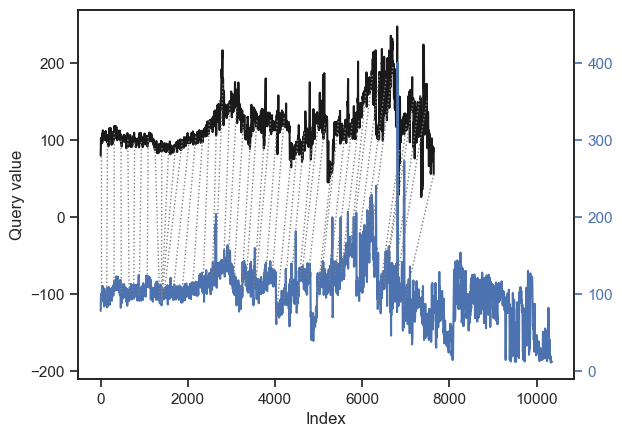

In [4]:
# Allocate Train_well#1 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].copy()
query_well = per_well[0].loc[per_well[0]['DEPT']>=1030.5].copy()
query_well.reset_index(drop=True, inplace=True)
alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[0].loc[per_well[0]['DEPT'] >= 1030.5, 'Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[0].loc[per_well[0]['DEPT'] >= 1030.5, 'Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

per_well[0].loc[per_well[0]['DEPT']<1030.5, 'Pseudo_TVD'] = per_well[0].loc[per_well[0]['DEPT']<1030.5, 'DEPT'] + int(per_well[0].loc[per_well[0]['DEPT']==1030.5, 'Pseudo_TVD']) - int(per_well[0].loc[per_well[0]['DEPT']==1030.5, 'DEPT'])
per_well[0].loc[(per_well[0]['DEPT']<=788.5) & (per_well[0]['Zone'].isna()), 'Zone'] = 0
per_well[0].loc[(per_well[0]['DEPT']>788.5) & (per_well[0]['Zone'].isna()), 'Zone'] = 1

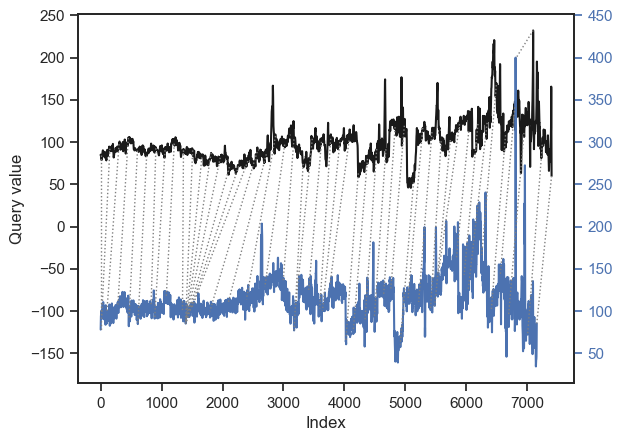

In [5]:
# Allocate Train_well#2 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].loc[per_well[6]['DEPT'] <= 4150, : ].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[1].loc[per_well[1]['DEPT'] >= 671, :].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=False, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[1].loc[per_well[1]['DEPT'] >= 671, 'Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[1].loc[per_well[1]['DEPT'] >= 671, 'Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

per_well[1].loc[per_well[1]['DEPT']>= 671,'Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[1].loc[per_well[1]['DEPT']>= 671,'Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))
per_well[1].loc[per_well[1]['DEPT']<671, 'Pseudo_TVD'] = per_well[1].loc[per_well[1]['DEPT']<671, 'DEPT'] + int(per_well[1].loc[per_well[1]['DEPT']==671, 'Pseudo_TVD']) - int(per_well[1].loc[per_well[1]['DEPT']==671, 'DEPT'])

per_well[1].loc[(per_well[1]['DEPT']<=480) & (per_well[1]['Zone'].isna()), 'Zone'] = 0
per_well[1].loc[per_well[1]['Zone'].isna(), 'Zone'] = 1

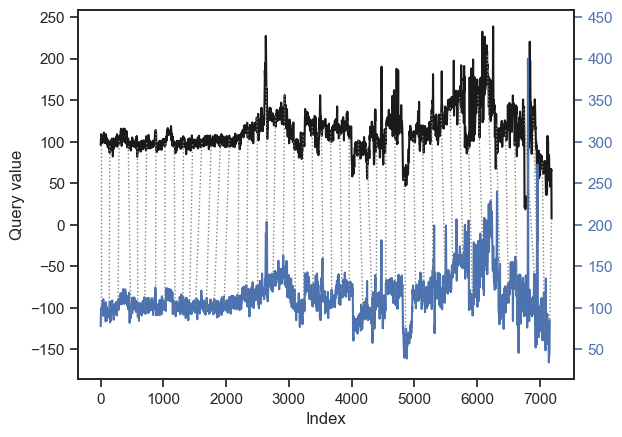

In [6]:
# Allocate Train_well#3 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].loc[per_well[6]['DEPT']<= 4150, :].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[2].loc[per_well[2]['DEPT'] >= 675, :].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=False, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[2].loc[per_well[2]['DEPT'] >= 675, 'Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[2].loc[per_well[2]['DEPT'] >= 675, 'Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

per_well[2].loc[per_well[2]['DEPT'] < 675, 'Pseudo_TVD'] = per_well[2].loc[per_well[2]['DEPT']<675, 'DEPT'] + int(per_well[2].loc[per_well[2]['DEPT']==675, 'Pseudo_TVD']) - int(per_well[2].loc[per_well[2]['DEPT']==675, 'DEPT'])
per_well[2].loc[(per_well[2]['DEPT'] <= 640.5) & (per_well[2]['Zone'].isna()), 'Zone'] = 1
per_well[2].loc[per_well[2]['Zone'].isna(), 'Zone'] = 0

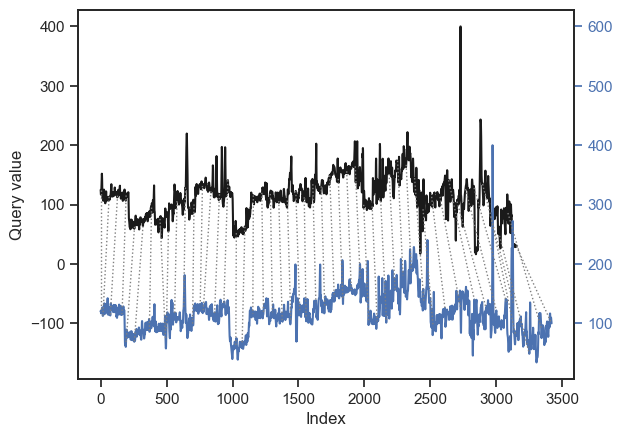

In [7]:
# Allocate Train_well#4 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].loc[(per_well[6]['DEPT']<=4200) & (per_well[6]['DEPT']>=2490), :].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[3].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=False, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[3]['Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[3]['Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

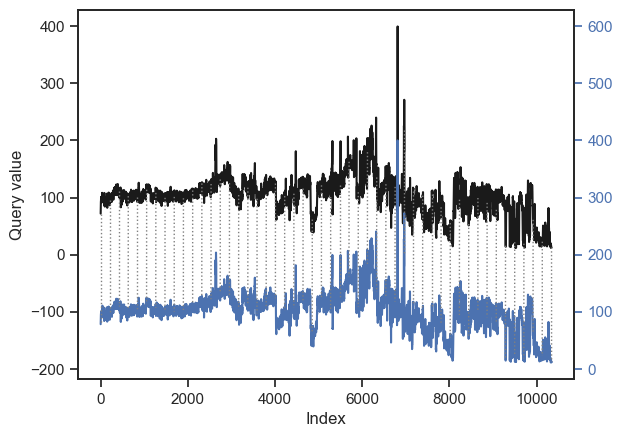

In [8]:
# Allocate Train_well#5 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[4].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=False, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[4]['Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[4]['Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

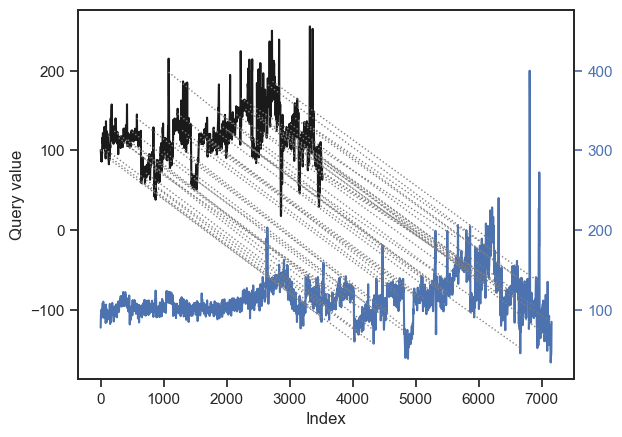

In [9]:
# Allocate Train_well#6 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].loc[per_well[6]['DEPT'] <= 4150].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[5].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=False, open_begin=True)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[5]['Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[5]['Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

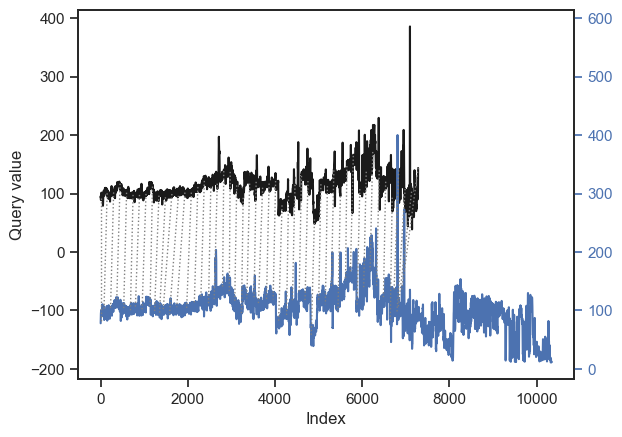

In [10]:
# Allocate Train_well#8 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[7].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[7]['Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[7]['Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))

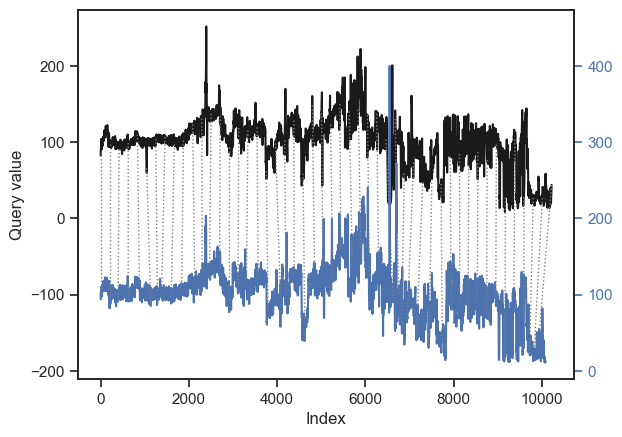

In [11]:
# Allocate Train_well#9 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6].iloc[260:].copy()
ref_well.reset_index(drop=True, inplace=True)

query_well = per_well[8].copy()
query_well.reset_index(drop=True, inplace=True)

alignment = dt.dtw(query_well['GR'], ref_well['GR'], step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=False)
alignment.plot(type='twoway', offset=-200)
index2 = alignment.index2

per_well[8]['Pseudo_TVD'] = np.array(ref_well['DEPT'][index2].reset_index(drop=True))
per_well[8]['Zone'] = np.array(ref_well['Zone'][index2].reset_index(drop=True))


In [12]:
per_well2 = pd.concat(per_well)

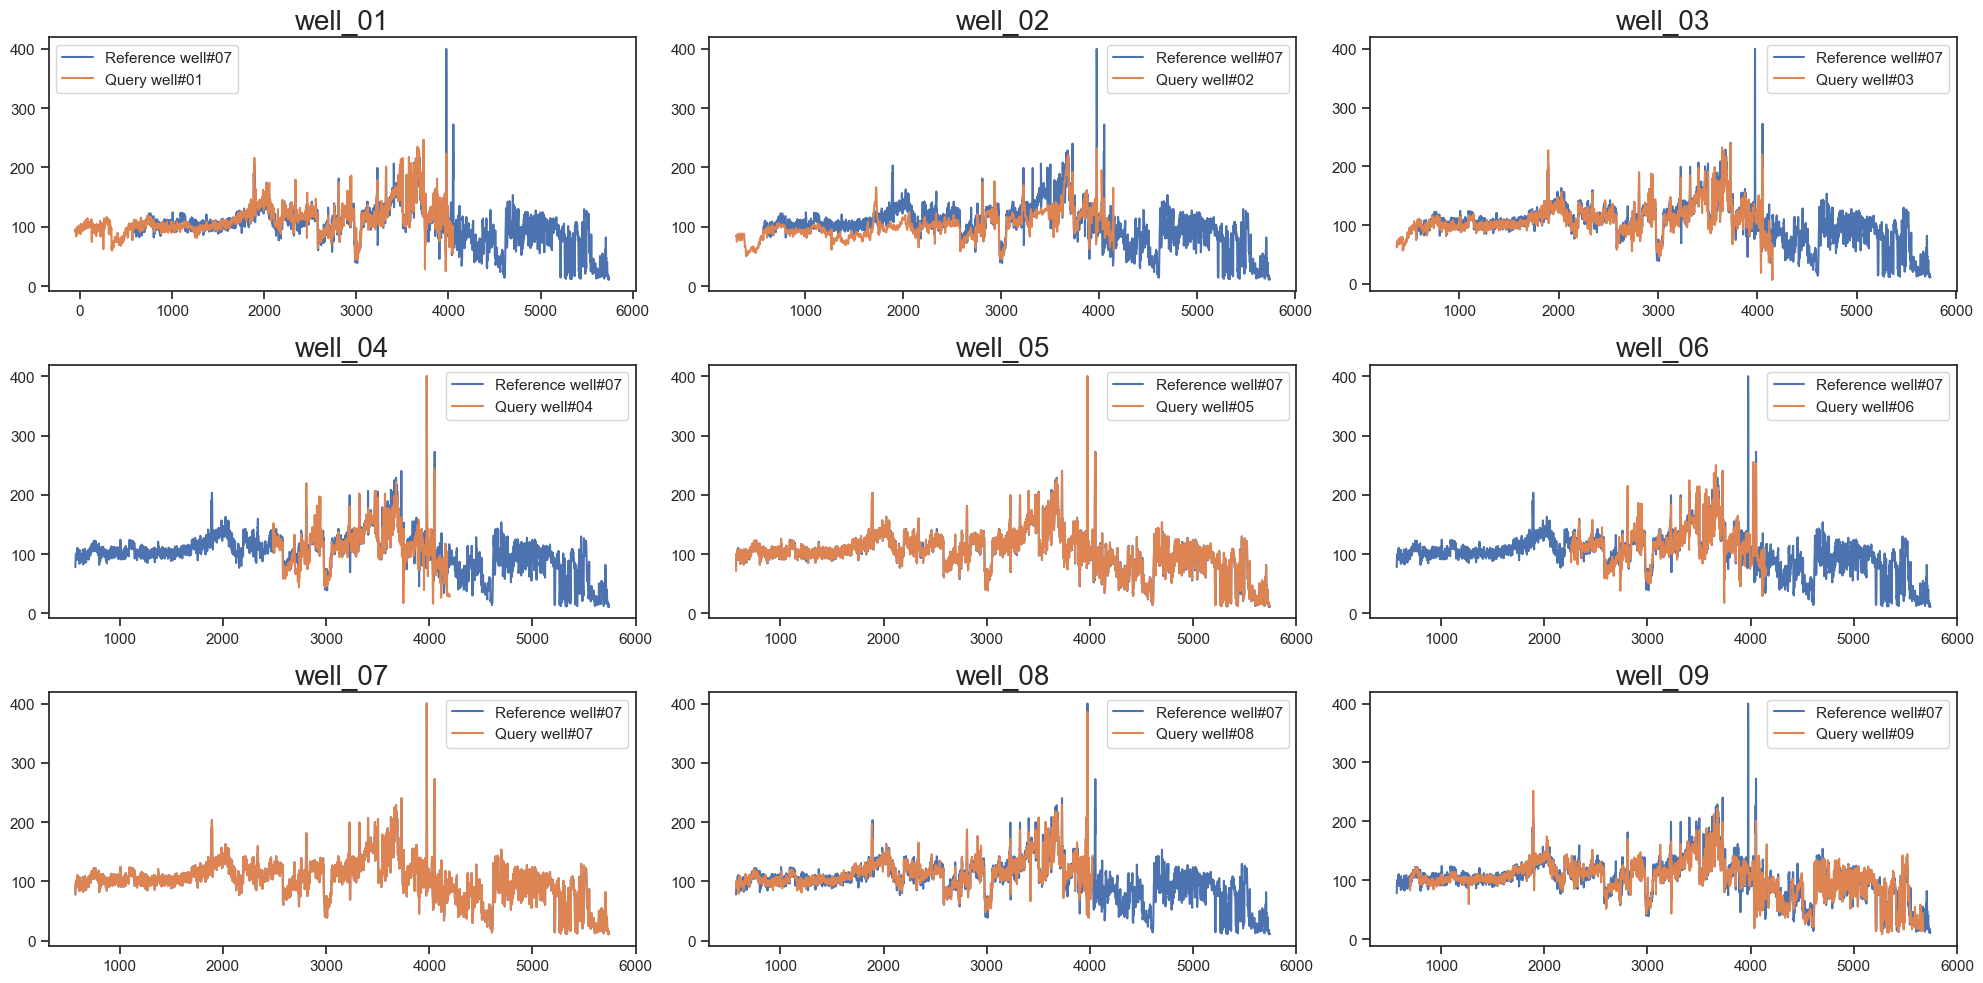

In [13]:
# plot Pseudo-TVD result by well

well_num = per_well2['well'].unique()

plt.figure(figsize=(20,10))
for _, i in enumerate(well_num):
    plt.subplot(3, 3, _+1)
    plt.plot(per_well2.loc[per_well2['well']=='07', 'Pseudo_TVD'], per_well2.loc[per_well2['well']=='07', 'GR'], label='Reference well#07')
    plt.plot(per_well2.loc[per_well2['well']==f'{i}', 'Pseudo_TVD'], per_well2.loc[per_well2['well']==f'{i}', 'GR'], label=f'Query well#{i}')
    plt.title(f'well_{i}', size=20)
    plt.legend()
plt.tight_layout()

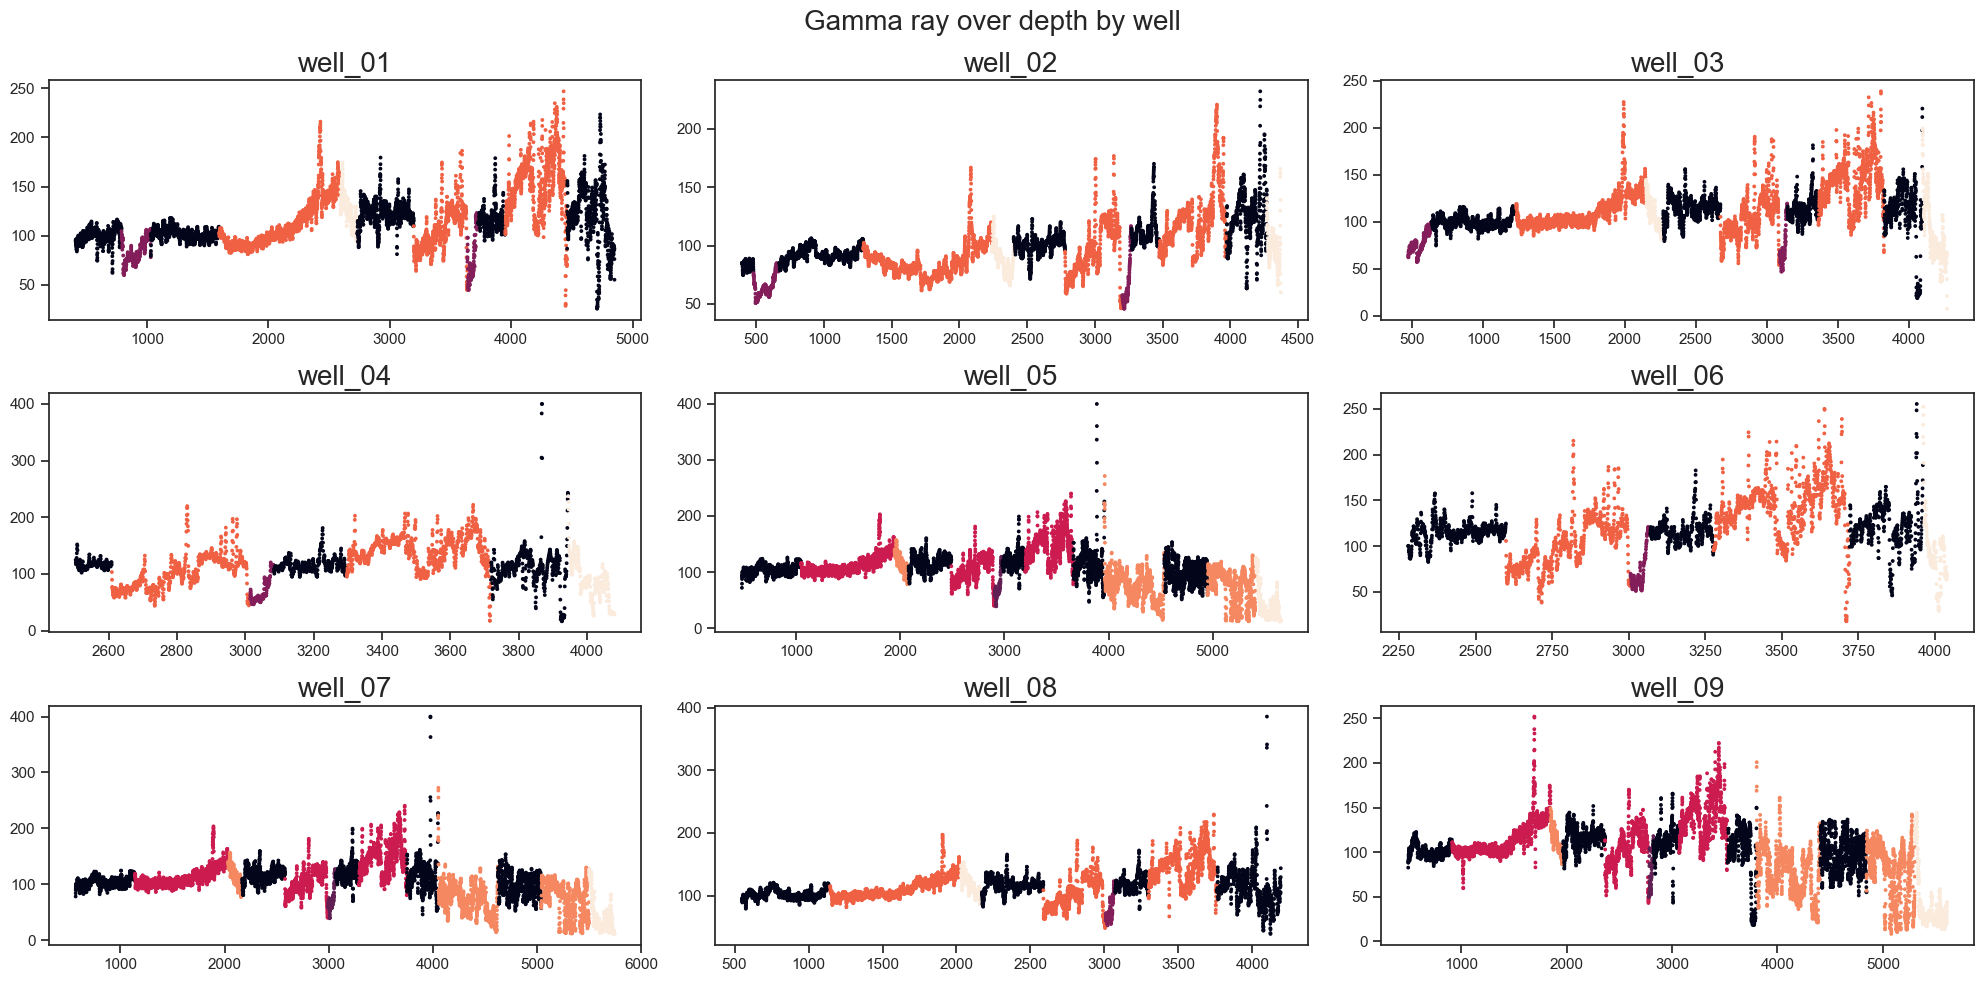

In [14]:
# Plot GR property with depth by well
# color means the zonation property

well_num = per_well2['well'].unique()

plt.figure(figsize=(20,10))
for _, i in enumerate(well_num):
    plt.subplot(3, 3, _+1)
    plt.scatter(per_well2.loc[per_well2['well']==f'{i}', 'DEPT'], per_well2.loc[per_well2['well']==f'{i}', 'GR'],
                c=per_well2.loc[per_well2['well']==f'{i}', 'Zone'], s=3)
    plt.title(f'well_{i}', size=20)
plt.suptitle('Gamma ray over depth by well', size=20)
plt.tight_layout()

Text(0.5, 0.98, 'Histogram of each property depending on zonation')

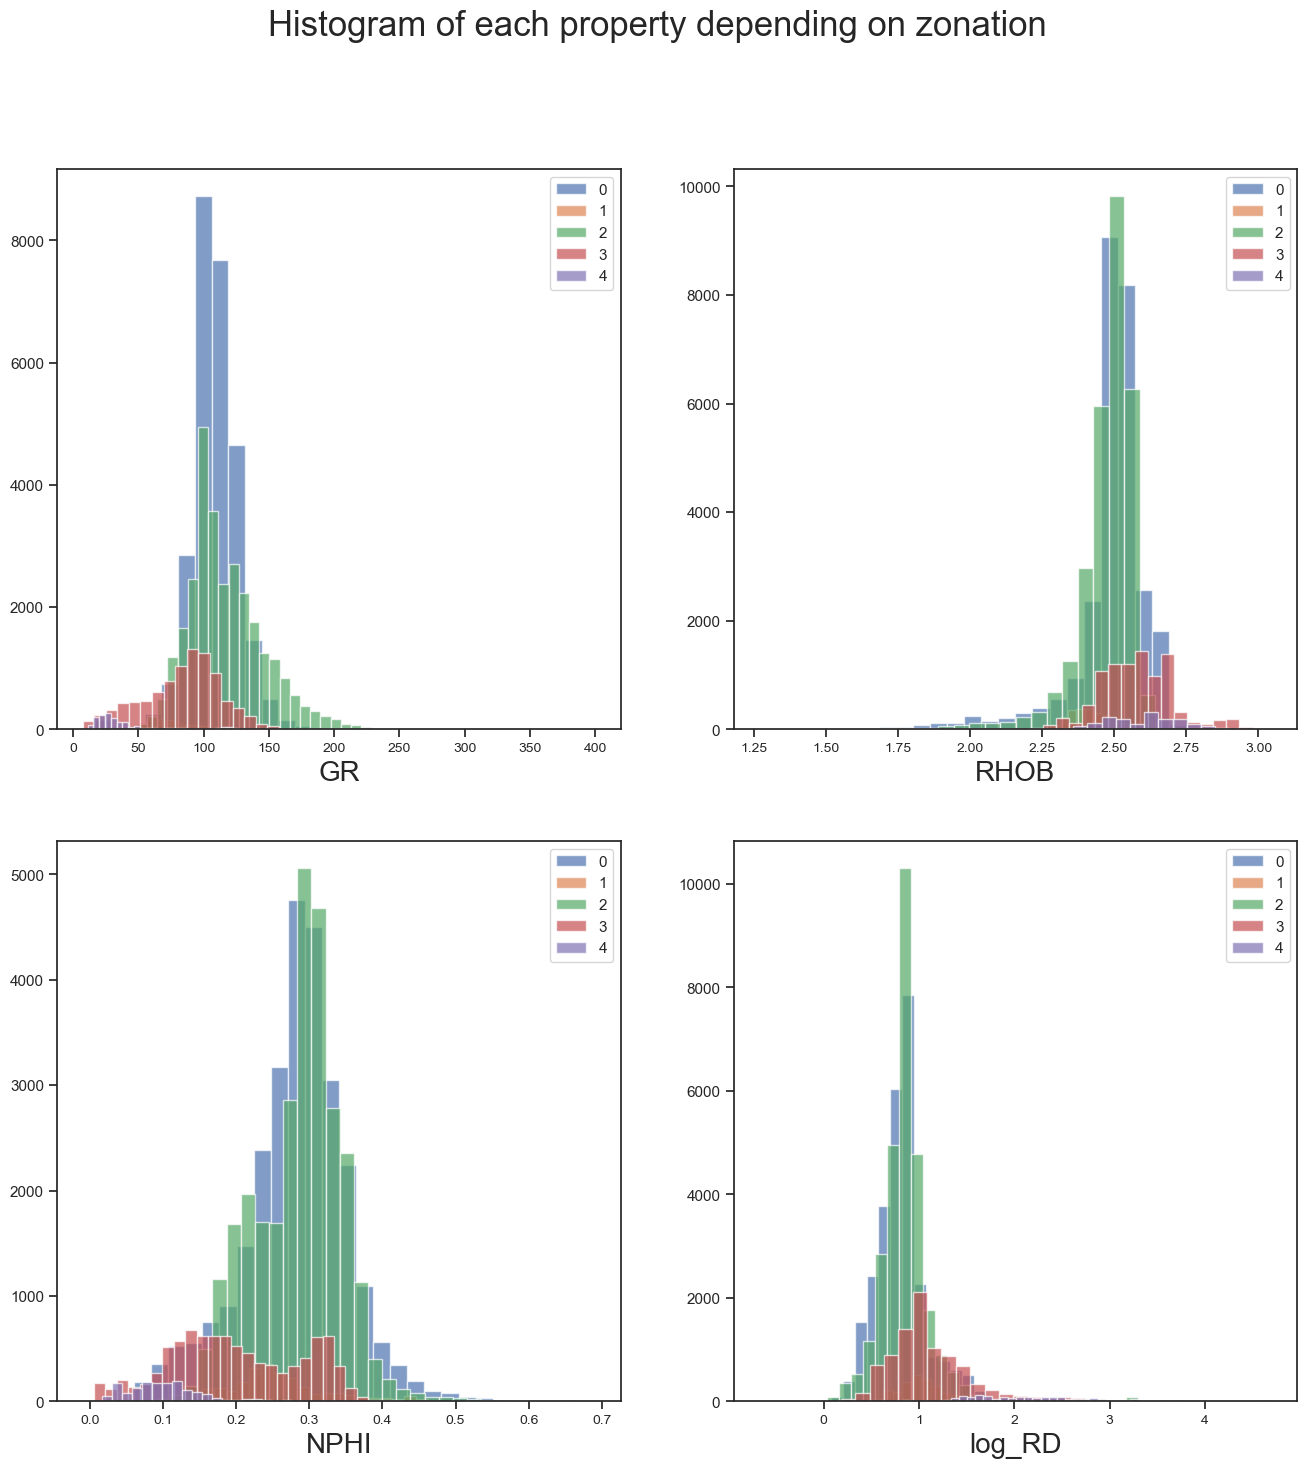

In [15]:
# plot the proprty histogram by zonation

zone_num = per_well2['Zone'].unique()
column = ['GR', 'RHOB', 'NPHI', 'log_RD']

plt.figure(figsize=(16,16))
for _, j in enumerate(column):
    plt.subplot(2,2,_+1)
    for i in zone_num:
        plt.hist(per_well2.loc[per_well2['Zone']==i, f'{j}'], bins=30, alpha=0.7, label=int(i))
        plt.xlabel(f'{j}', size=20)
        plt.xticks(size=10)
        plt.legend()
plt.suptitle('Histogram of each property depending on zonation', size=25)

### <a>3.4. Data cropping</a>

In [16]:
# When making Pseudo-TVD property using DTW, a number of data points of query well were allocated to a data point of reference well(Train_well#7)
# It is easy for the training data to be bias and the model learns to rely more on TVD property
# the numbers of data at each TVD values are limited to maximum 9

per_well2.drop(per_well2[per_well2['RD'] < 1].index, axis=0, inplace=True)
per_well3 = pd.DataFrame()
for i in per_well2['Pseudo_TVD'].unique():
    if len(per_well2.loc[per_well2['Pseudo_TVD']==i, :]) > 9:
        per_well3 = pd.concat([per_well3, per_well2.loc[per_well2['Pseudo_TVD']==i, :].sample(5)])
    else:
        per_well3 = pd.concat([per_well3, per_well2.loc[per_well2['Pseudo_TVD']==i, :]])
per_well2 = per_well3.copy()

### <a>3.5. Train/Test data split</a>

In [17]:
train_well, val_well = train_test_split(per_well2, test_size=.1, random_state=42, shuffle=True, stratify=per_well2[['Zone', 'well']])

### <a>3.6. Scailing</a>

In [18]:
# scale the each property

scaler1 = MinMaxScaler()
scaler1.fit(np.asarray(per_well2['Pseudo_TVD']).reshape(-1,1))
train_well['Pseudo_TVD'] = scaler1.transform(np.asarray(train_well['Pseudo_TVD']).reshape(-1,1))
val_well['Pseudo_TVD'] = scaler1.transform(np.asarray(val_well['Pseudo_TVD']).reshape(-1,1))


scaler2 = MinMaxScaler()
train_well['GR'] = scaler2.fit_transform(np.asarray(train_well['GR']).reshape(-1,1))
val_well['GR'] = scaler2.transform(np.asarray(val_well['GR']).reshape(-1,1))

scaler3 = MinMaxScaler()
train_well['NPHI'] = scaler3.fit_transform(np.asarray(train_well['NPHI']).reshape(-1,1))
val_well['NPHI'] = scaler3.transform(np.asarray(val_well['NPHI']).reshape(-1,1))

scaler4 = MinMaxScaler()
train_well['RHOB'] = scaler4.fit_transform(np.asarray(train_well['RHOB']).reshape(-1,1))
val_well['RHOB'] = scaler4.transform(np.asarray(val_well['RHOB']).reshape(-1,1))

scaler5 = MinMaxScaler()
train_well['log_RD'] = scaler5.fit_transform(np.asarray(train_well['log_RD']).reshape(-1,1))
val_well['log_RD'] = scaler5.transform(np.asarray(val_well['log_RD']).reshape(-1,1))

## <a>4. Training ML model</a>

### <a>4.1. Train ML model</a>

In [19]:
# train a hierarchical model that sequentially predicts NPHI, log_RD, and RHOB properties.

x_feat1 = ['Pseudo_TVD', 'GR']
y_feat1 = ['NPHI']

x_feat2 = ['Pseudo_TVD', 'GR', 'NPHI']
y_feat2 = ['log_RD']

x_feat3 = ['Pseudo_TVD', 'GR', 'NPHI', 'log_RD']
y_feat3 = ['RHOB']

y_train_pred = train_well[['Pseudo_TVD', 'GR', 'Zone']].copy()
y_val_pred = val_well[['Pseudo_TVD', 'GR', 'Zone']].copy()

unique_zones = per_well2['Zone'].unique()
zone_mapping = {zone: i for i, zone in enumerate(unique_zones)}

r2_zone_train = np.zeros((3, len(unique_zones)))
r2_zone_val = np.zeros((3, len(unique_zones)))

models = []

for i, zone in enumerate(per_well2['Zone'].unique()):
    zone_index = zone_mapping[zone]
    
    rf_reg1 = RandomForestRegressor(n_estimators=100, random_state=100, n_jobs=-1)
    rf_reg1.fit(train_well.loc[train_well['Zone']==zone, x_feat1], train_well.loc[train_well['Zone']==zone, y_feat1])
    y_train_pred.loc[y_train_pred['Zone']==zone, 'NPHI'] = rf_reg1.predict(train_well.loc[train_well['Zone']==zone, x_feat1])
    if len(val_well.loc[val_well['Zone']==zone]) != 0:
        y_val_pred.loc[y_val_pred['Zone']==zone, 'NPHI'] = rf_reg1.predict(val_well.loc[val_well['Zone']==zone, x_feat1])

    r2_zone_train[0, zone_index] = r2_score(train_well.loc[train_well['Zone']==zone, 'NPHI'], y_train_pred.loc[y_train_pred['Zone']==zone, 'NPHI'])
    if len(val_well.loc[val_well['Zone']==zone]) != 0:
        r2_zone_val[0, zone_index] = r2_score(val_well.loc[val_well['Zone']==zone, 'NPHI'], y_val_pred.loc[y_val_pred['Zone']==zone, 'NPHI'])
    
    for _, j in enumerate(y_feat1):
        train_well.loc[train_well['Zone']==zone, '{}_pred'.format(j)] = y_train_pred.loc[y_train_pred['Zone']==zone, j]
        val_well.loc[val_well['Zone']==zone, '{}_pred'.format(j)] =  y_val_pred.loc[y_val_pred['Zone']==zone, j]
    
    rf_reg2 = RandomForestRegressor(n_estimators=100, random_state=100, n_jobs=-1)
    rf_reg2.fit(train_well.loc[train_well['Zone']==zone, x_feat2], train_well.loc[train_well['Zone']==zone, y_feat2])
    y_train_pred.loc[y_train_pred['Zone']==zone, 'log_RD'] = rf_reg2.predict(y_train_pred.loc[y_train_pred['Zone']==zone, x_feat2])
    if len(val_well.loc[val_well['Zone']==zone]) != 0:
        y_val_pred.loc[y_val_pred['Zone']==zone, 'log_RD'] = rf_reg2.predict(y_val_pred.loc[y_val_pred['Zone']==zone, x_feat2])
        r2_zone_val[1, zone_index] = r2_score(val_well.loc[val_well['Zone']==zone, 'log_RD'], y_val_pred.loc[y_val_pred['Zone']==zone, 'log_RD'])
    r2_zone_train[1, zone_index] = r2_score(train_well.loc[train_well['Zone']==zone, 'log_RD'], y_train_pred.loc[y_train_pred['Zone']==zone, 'log_RD'])
    


    for _, j in enumerate(y_feat2):
        train_well.loc[train_well['Zone']==zone, '{}_pred'.format(j)] = y_train_pred.loc[y_train_pred['Zone']==zone,j]
        val_well.loc[val_well['Zone']==zone, '{}_pred'.format(j)] = y_val_pred.loc[y_val_pred['Zone']==zone, j] 
    
    rf_reg3 = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    rf_reg3.fit(train_well.loc[train_well['Zone']==zone, x_feat3], train_well.loc[train_well['Zone']==zone, y_feat3])
    y_train_pred.loc[y_train_pred['Zone']==zone,'RHOB'] = rf_reg3.predict(y_train_pred.loc[y_train_pred['Zone']==zone, x_feat3])
    if len(val_well.loc[val_well['Zone']==zone]) != 0:
        y_val_pred.loc[y_val_pred['Zone']==zone,'RHOB'] = rf_reg3.predict(y_val_pred.loc[y_val_pred['Zone']==zone, x_feat3])
        r2_zone_val[2, i] = r2_score(val_well.loc[val_well['Zone']==zone, 'RHOB'], y_val_pred.loc[y_val_pred['Zone']==zone,'RHOB'])
    r2_zone_train[2, i] = r2_score(train_well.loc[train_well['Zone']==zone, 'RHOB'], y_train_pred.loc[y_train_pred['Zone']==zone,'RHOB'])
    

    for _, j in enumerate(y_feat3):
        train_well.loc[train_well['Zone']==zone, '{}_pred'.format(j)] = y_train_pred.loc[y_train_pred['Zone']==zone,j]
        val_well.loc[val_well['Zone']==zone, '{}_pred'.format(j)] = y_val_pred.loc[y_val_pred['Zone']==zone, j]

    models.append([rf_reg1, rf_reg2, rf_reg3])

C:\Users\DELL\AppData\Local\Temp\ipykernel_28736\4213689042.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg1.fit(train_well.loc[train_well['Zone']==zone, x_feat1], train_well.loc[train_well['Zone']==zone, y_feat1])
C:\Users\DELL\AppData\Local\Temp\ipykernel_28736\4213689042.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg2.fit(train_well.loc[train_well['Zone']==zone, x_feat2], train_well.loc[train_well['Zone']==zone, y_feat2])
C:\Users\DELL\AppData\Local\Temp\ipykernel_28736\4213689042.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg3.fit(train_well.loc[train_well['Zone']==zone, x_feat3], train_well.loc[train_well['Zone']==zo

![screensh](../SPWLA%20모델%20모식도_v2.jpg)

### <a>4.2. Re-scailing</a>

In [20]:
# re-scale the predicted property

train_well['Pseudo_TVD'] = scaler1.inverse_transform(np.asarray(train_well['Pseudo_TVD']).reshape(-1,1))
val_well['Pseudo_TVD'] = scaler1.inverse_transform(np.asarray(val_well['Pseudo_TVD']).reshape(-1,1))

train_well['GR'] = scaler2.inverse_transform(np.asarray(train_well['GR']).reshape(-1,1))
val_well['GR'] = scaler2.inverse_transform(np.asarray(val_well['GR']).reshape(-1,1))

train_well['NPHI'] = scaler3.inverse_transform(np.asarray(train_well['NPHI']).reshape(-1,1))
train_well['NPHI_pred'] = scaler3.inverse_transform(np.asarray(train_well['NPHI_pred']).reshape(-1,1))

val_well['NPHI'] = scaler3.inverse_transform(np.asarray(val_well['NPHI']).reshape(-1,1))
val_well['NPHI_pred'] = scaler3.inverse_transform(np.asarray(val_well['NPHI_pred']).reshape(-1,1))

train_well['RHOB'] = scaler4.inverse_transform(np.asarray(train_well['RHOB']).reshape(-1,1))
train_well['RHOB_pred'] = scaler4.inverse_transform(np.asarray(train_well['RHOB_pred']).reshape(-1,1))

val_well['RHOB'] = scaler4.inverse_transform(np.asarray(val_well['RHOB']).reshape(-1,1))
val_well['RHOB_pred'] = scaler4.inverse_transform(np.asarray(val_well['RHOB_pred']).reshape(-1,1))

train_well['log_RD'] = scaler5.inverse_transform(np.asarray(train_well['log_RD']).reshape(-1,1))
train_well['log_RD_pred'] = scaler5.inverse_transform(np.asarray(train_well['log_RD_pred']).reshape(-1,1))

val_well['log_RD'] = scaler5.inverse_transform(np.asarray(val_well['log_RD']).reshape(-1,1))
val_well['log_RD_pred'] = scaler5.inverse_transform(np.asarray(val_well['log_RD_pred']).reshape(-1,1))

### <a>4.3. Cross-plot of prediction and actual values</a>

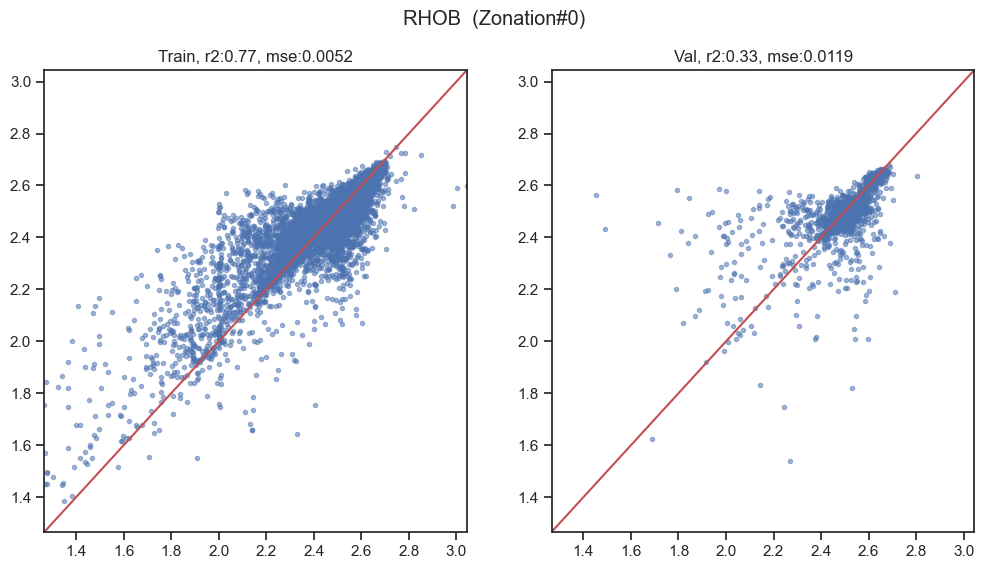

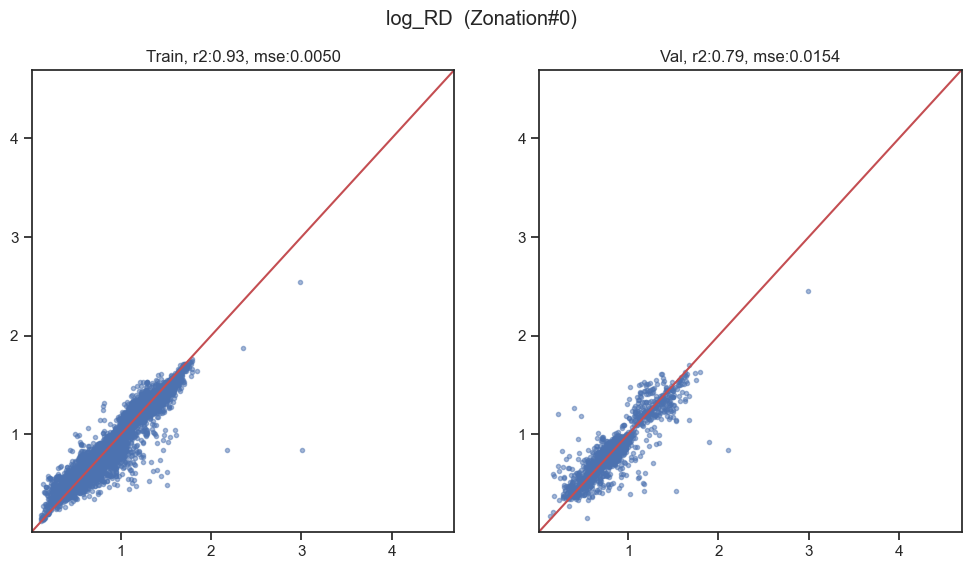

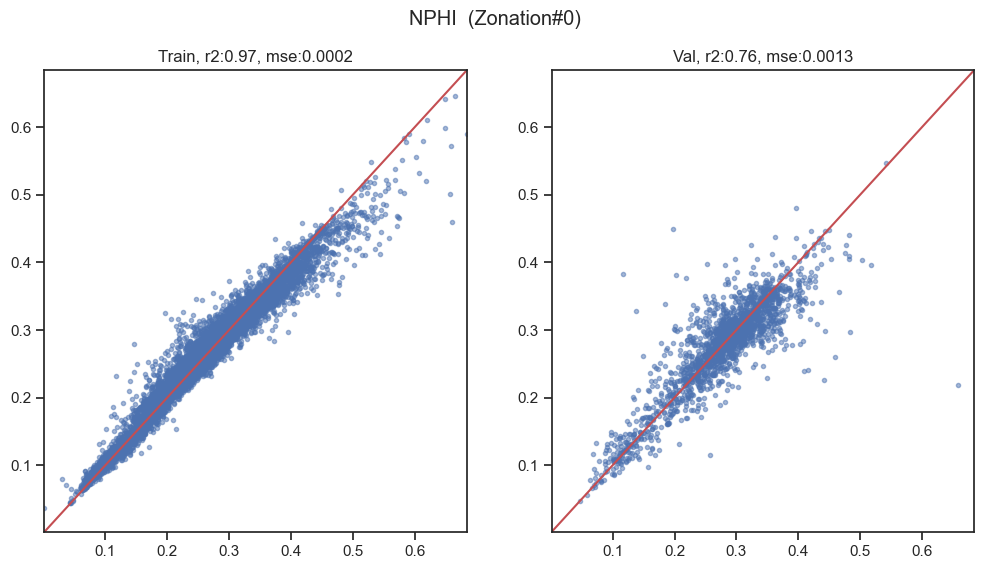

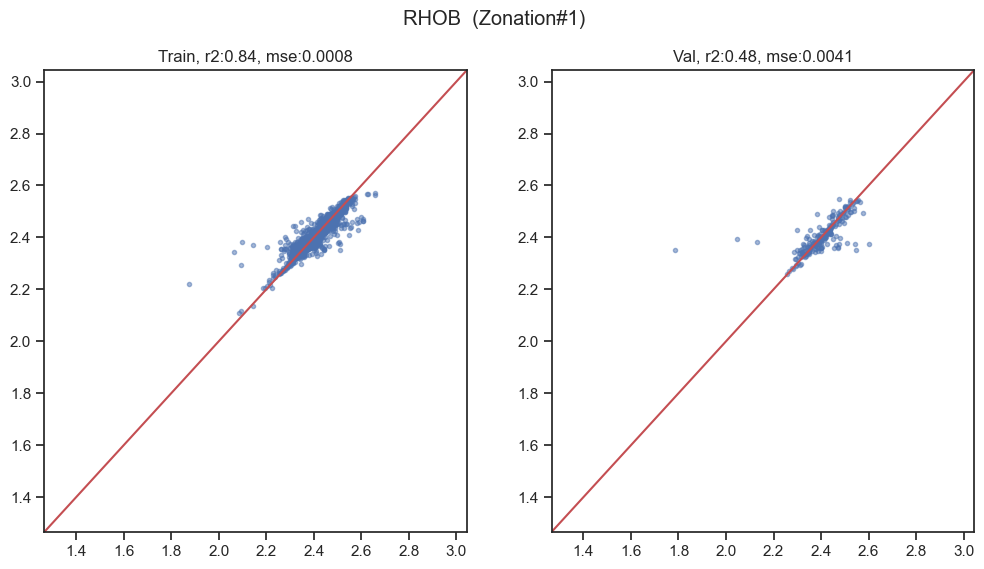

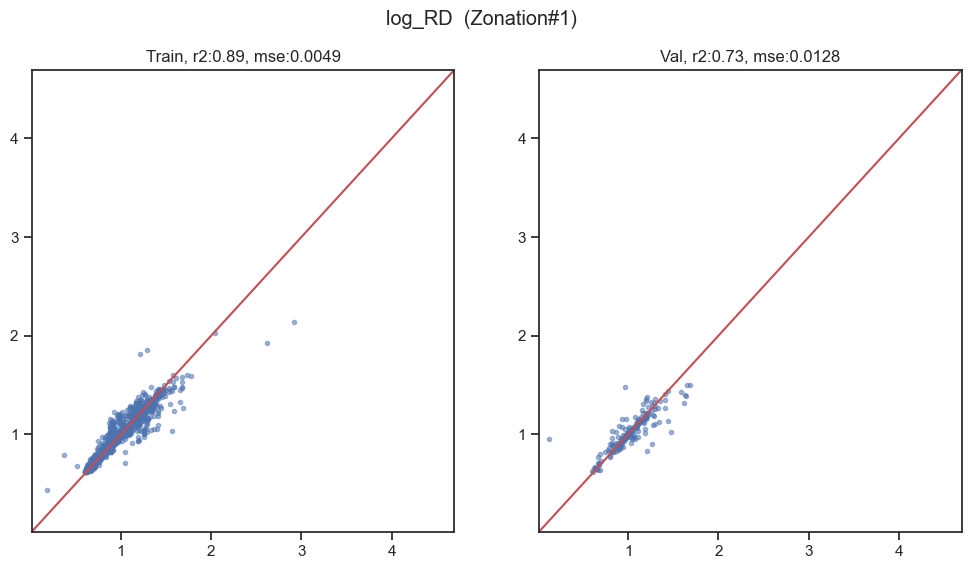

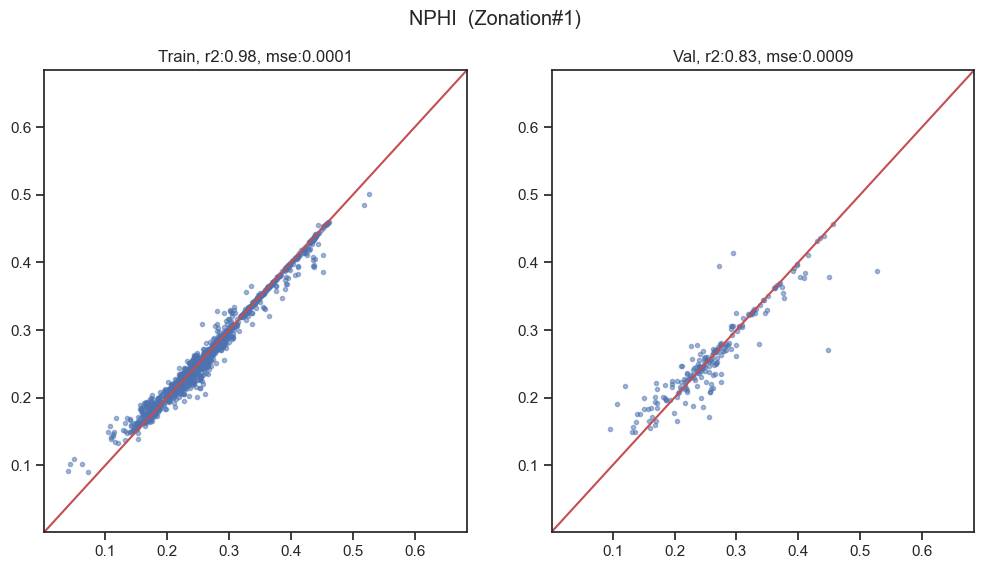

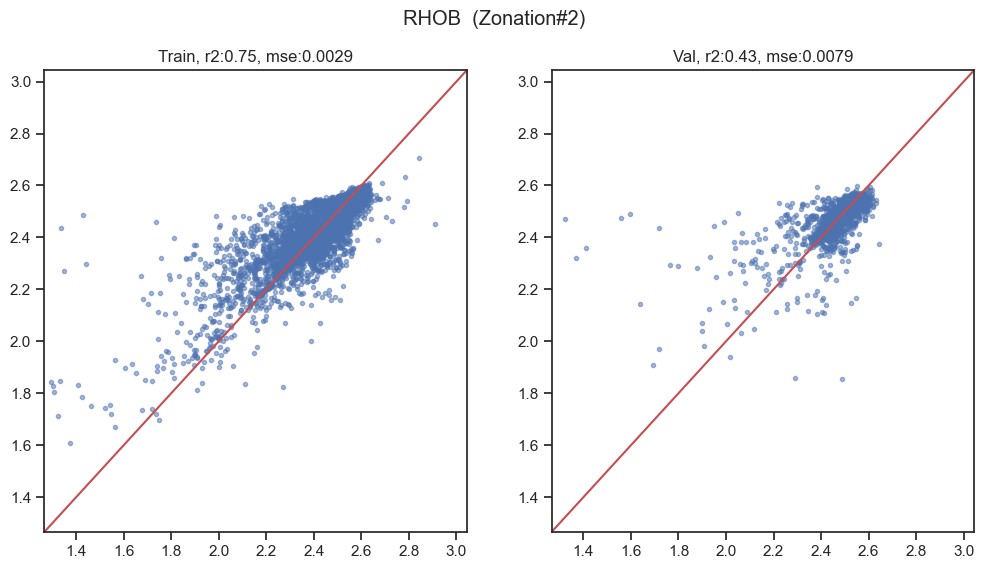

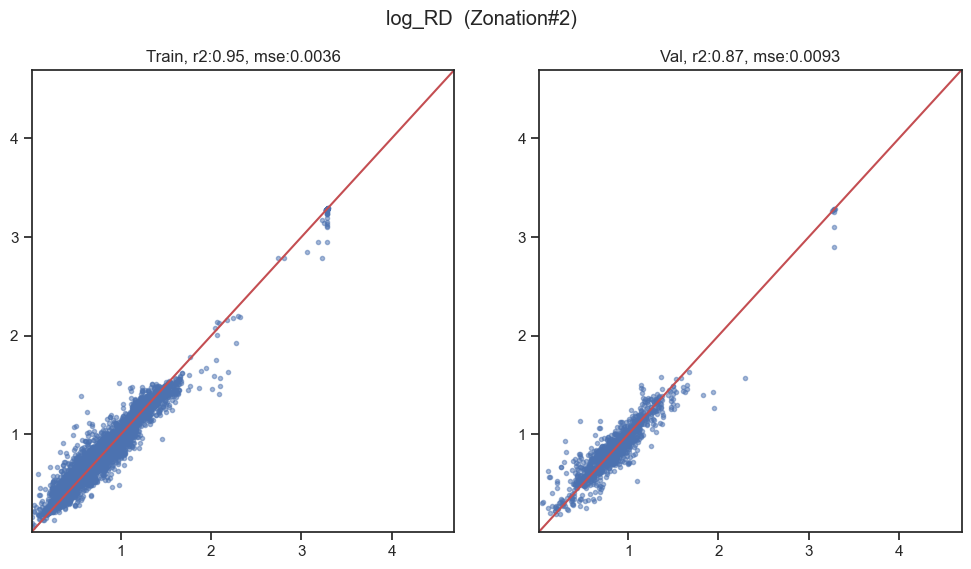

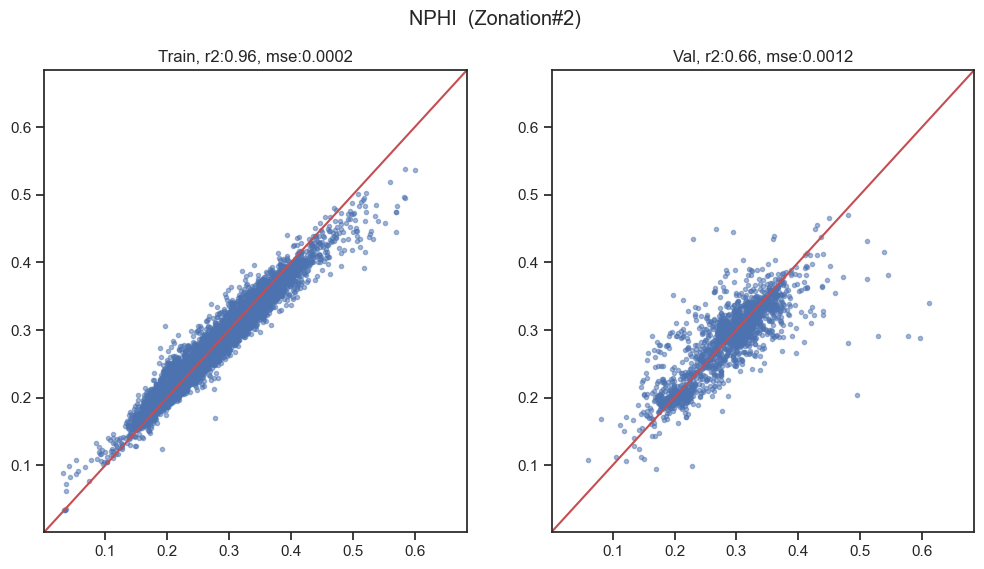

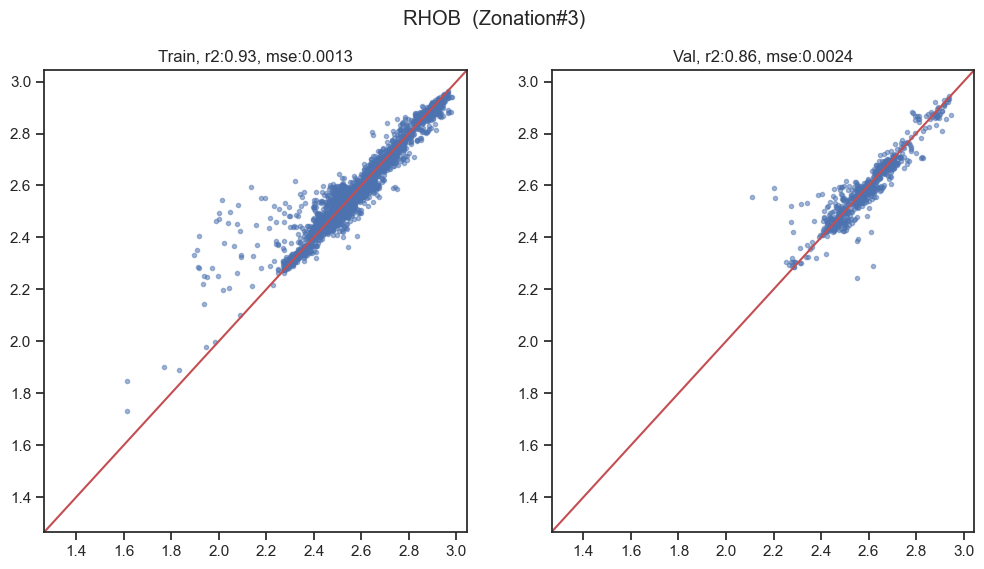

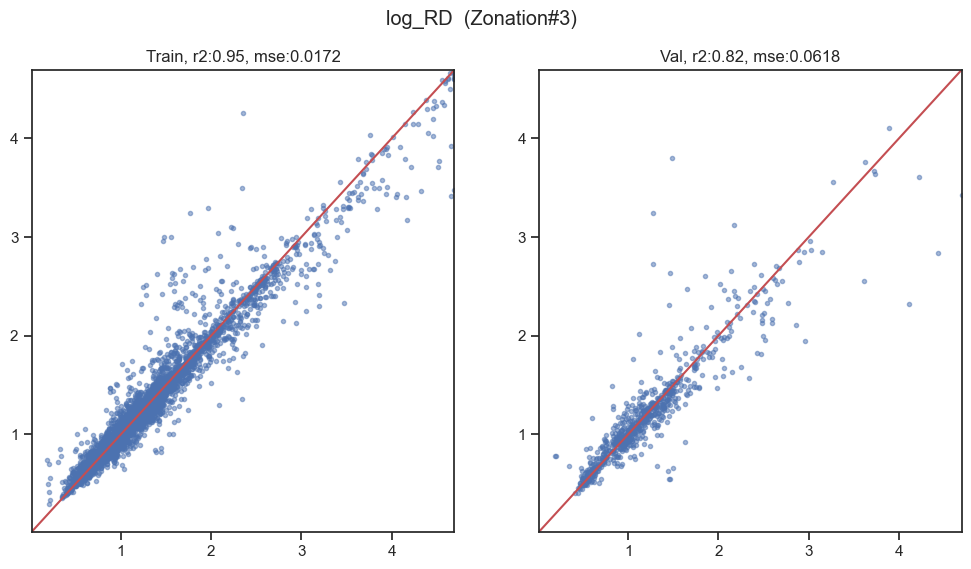

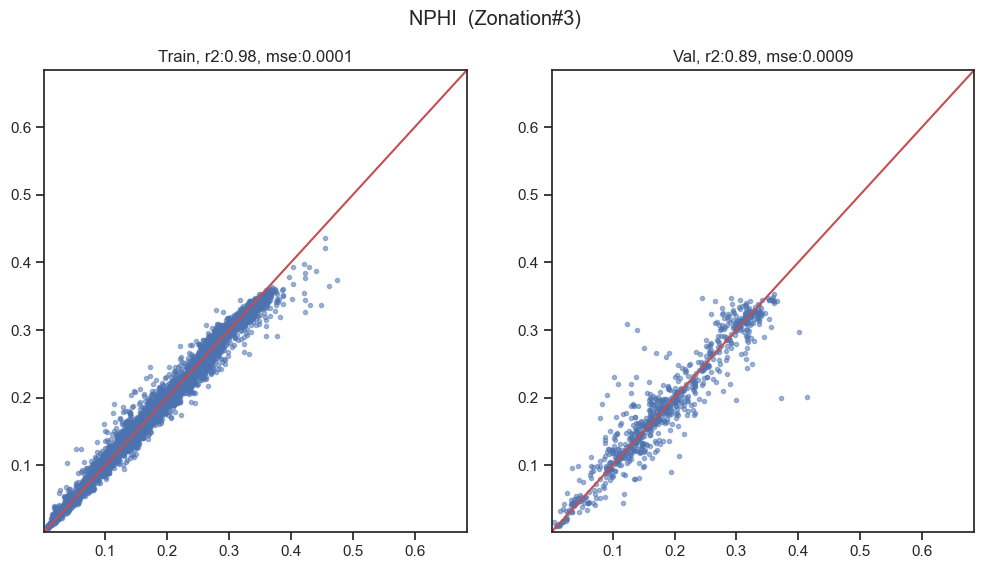

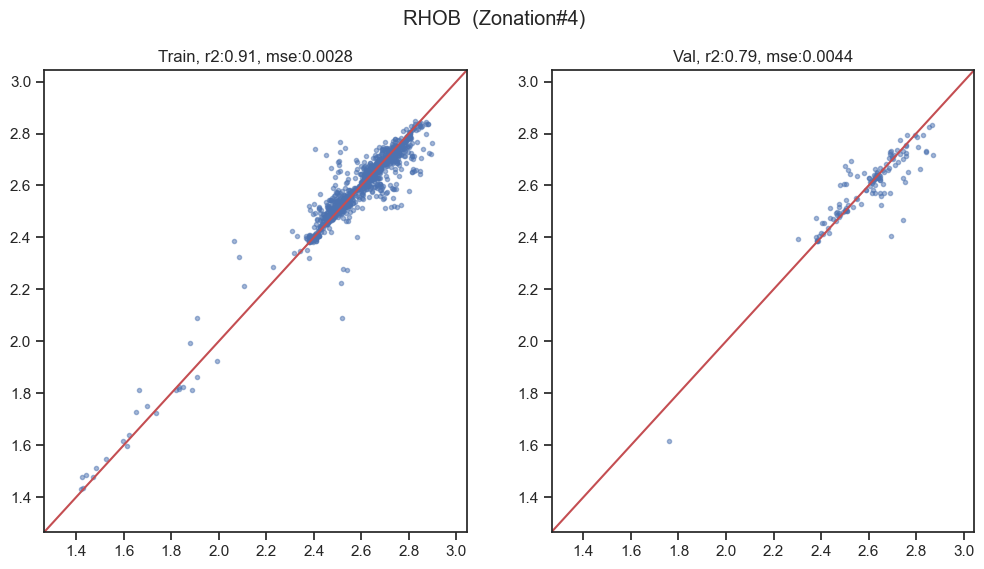

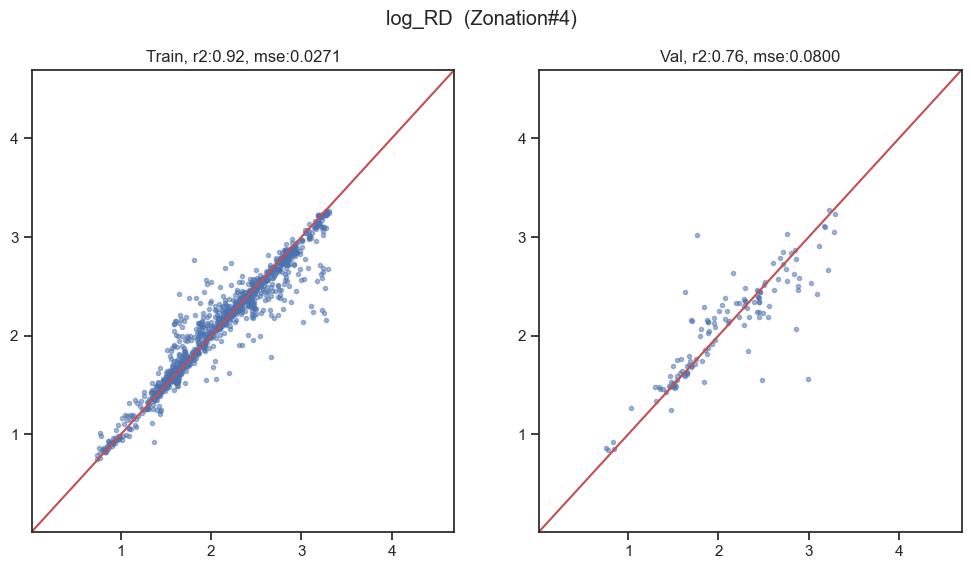

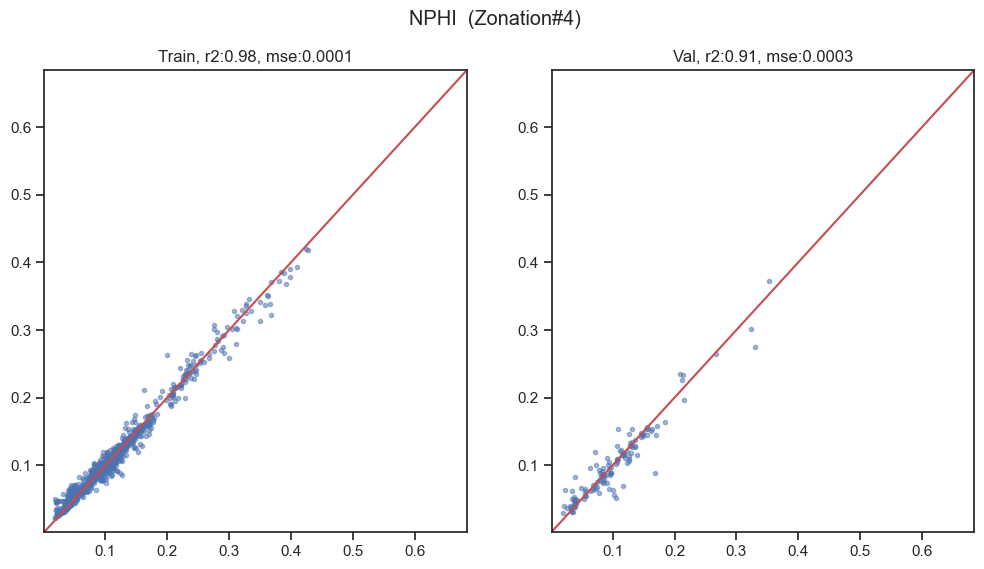

In [21]:
# plot the predicted value with the real value by property and zonation to validate the model capacity.

y_feat = ['RHOB', 'log_RD', 'NPHI']
for zone in per_well2['Zone'].unique():
    for i, feat in enumerate(y_feat):
        x_min, x_max = train_well[feat].min(), train_well[feat].max()
        solid_line = [x_min, x_max]

        x_min2, x_max2 = val_well.loc[val_well['Zone']==zone, feat].min(), val_well.loc[val_well['Zone']==zone, feat].max()
        solid_line2 = [x_min2, x_max2]
        r2_train = r2_score(train_well.loc[train_well['Zone']==zone, feat], train_well.loc[train_well['Zone']==zone, '{}_pred'.format(feat)])
        r2_val = r2_score(val_well.loc[val_well['Zone']==zone, feat], val_well.loc[val_well['Zone']==zone, '{}_pred'.format(feat)])
        mse_train = mean_squared_error(train_well.loc[train_well['Zone']==zone, feat], train_well.loc[train_well['Zone']==zone, '{}_pred'.format(feat)])
        mse_val = mean_squared_error(val_well.loc[val_well['Zone']==zone, feat], val_well.loc[val_well['Zone']==zone, '{}_pred'.format(feat)])


        plt.figure(figsize=(12,6))

        plt.suptitle('{}  (Zonation#{})'.format(feat, int(zone)))
        
        plt.subplot(121)
        plt.plot(train_well.loc[train_well['Zone']==zone, feat], train_well.loc[train_well['Zone']==zone, '{}_pred'.format(feat)], '.', alpha=0.5)
        plt.plot(solid_line, solid_line, c='r')
        plt.xlim(x_min, x_max)
        plt.ylim(x_min, x_max)
        plt.title('Train, r2:{:.2f}, mse:{:.4f}'.format(r2_train, mse_train))

        plt.subplot(122)
        plt.plot(val_well.loc[val_well['Zone']==zone, feat], val_well.loc[val_well['Zone']==zone, '{}_pred'.format(feat)], '.', alpha=0.5)
        plt.plot(solid_line, solid_line, c='r')
        plt.xlim(x_min, x_max)
        plt.ylim(x_min, x_max)
        plt.title('Val, r2:{:.2f}, mse:{:.4f}'.format(r2_val, mse_val))

## <a>5. Prediction</a>

### <a>5.1. Load test data</a>

In [22]:
test_well_list = os.listdir('data/test/')

if 'README.md' in test_well_list:
    test_well_list.remove('README.md')

test_per_well = []

for i in test_well_list:
    well = pd.read_csv('data/test/{}'.format(i))
    well['well'] = int(i.split('_')[-1].split('.')[0])
    test_per_well.append(well)
    

### <a>5.2. Test data preprocessing</a>

<Axes: xlabel='Index', ylabel='Query value'>

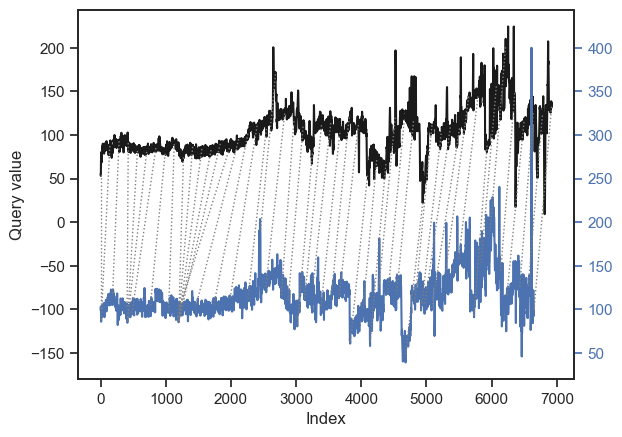

In [23]:
# Allocate Test_well#1 to new properties(TVD, zonation) using DTW algorithm

query_well2 = test_per_well[0]['GR']
ref_well2 = per_well[6]['GR'].copy()
ref_well2 = ref_well2.iloc[200:6850]
ref_well2.reset_index(drop=True, inplace=True)

index1 = []
index2 = []
alignment = dt.dtw(query_well2, ref_well2, step_pattern='asymmetric', keep_internals=True, open_end=False, open_begin=False)
index1.append(alignment.index1)
index2.append(alignment.index2)
alignment.plot(type='twoway', offset=-200)

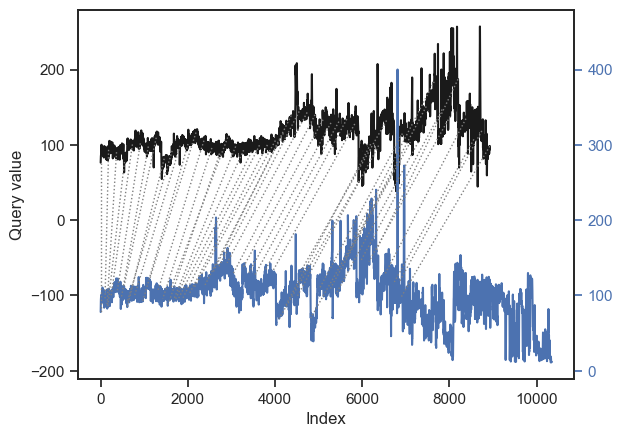

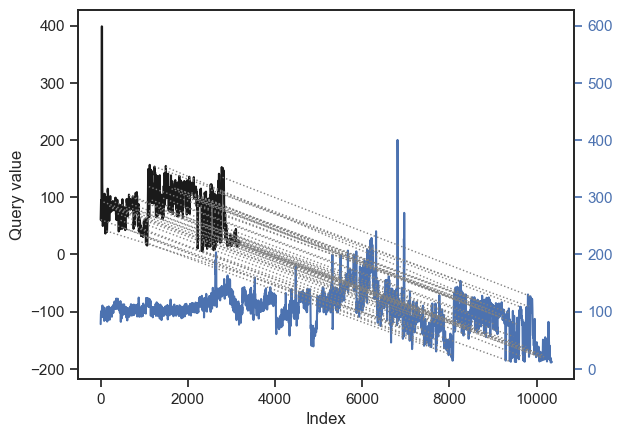

In [24]:
# Allocate Test_well#2 and #3 to new properties(TVD, zonation) using DTW algorithm

ref_well = per_well[6]['GR'].copy()
for query in test_per_well[1:3]:
    alignment = dt.dtw(query['GR'], ref_well, step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=True)
    index1.append(alignment.index1)
    index2.append(alignment.index2)
    alignment.plot(type='twoway', offset=-200)

ref_well = per_well[6].copy()
for i in range(len(test_per_well)):
    if i == 0:
        test_per_well[i]['Pseudo_TVD'] = ref_well['DEPT'][index2[i]+200].reset_index(drop=True)
        test_per_well[i]['Zone'] = ref_well['Zone'][index2[i]+200].reset_index(drop=True)
    else:
        test_per_well[i]['Pseudo_TVD'] = ref_well['DEPT'][index2[i]].reset_index(drop=True)
        test_per_well[i]['Zone'] = ref_well['Zone'][index2[i]].reset_index(drop=True)

In [25]:
test_per_well2 = pd.concat(test_per_well)

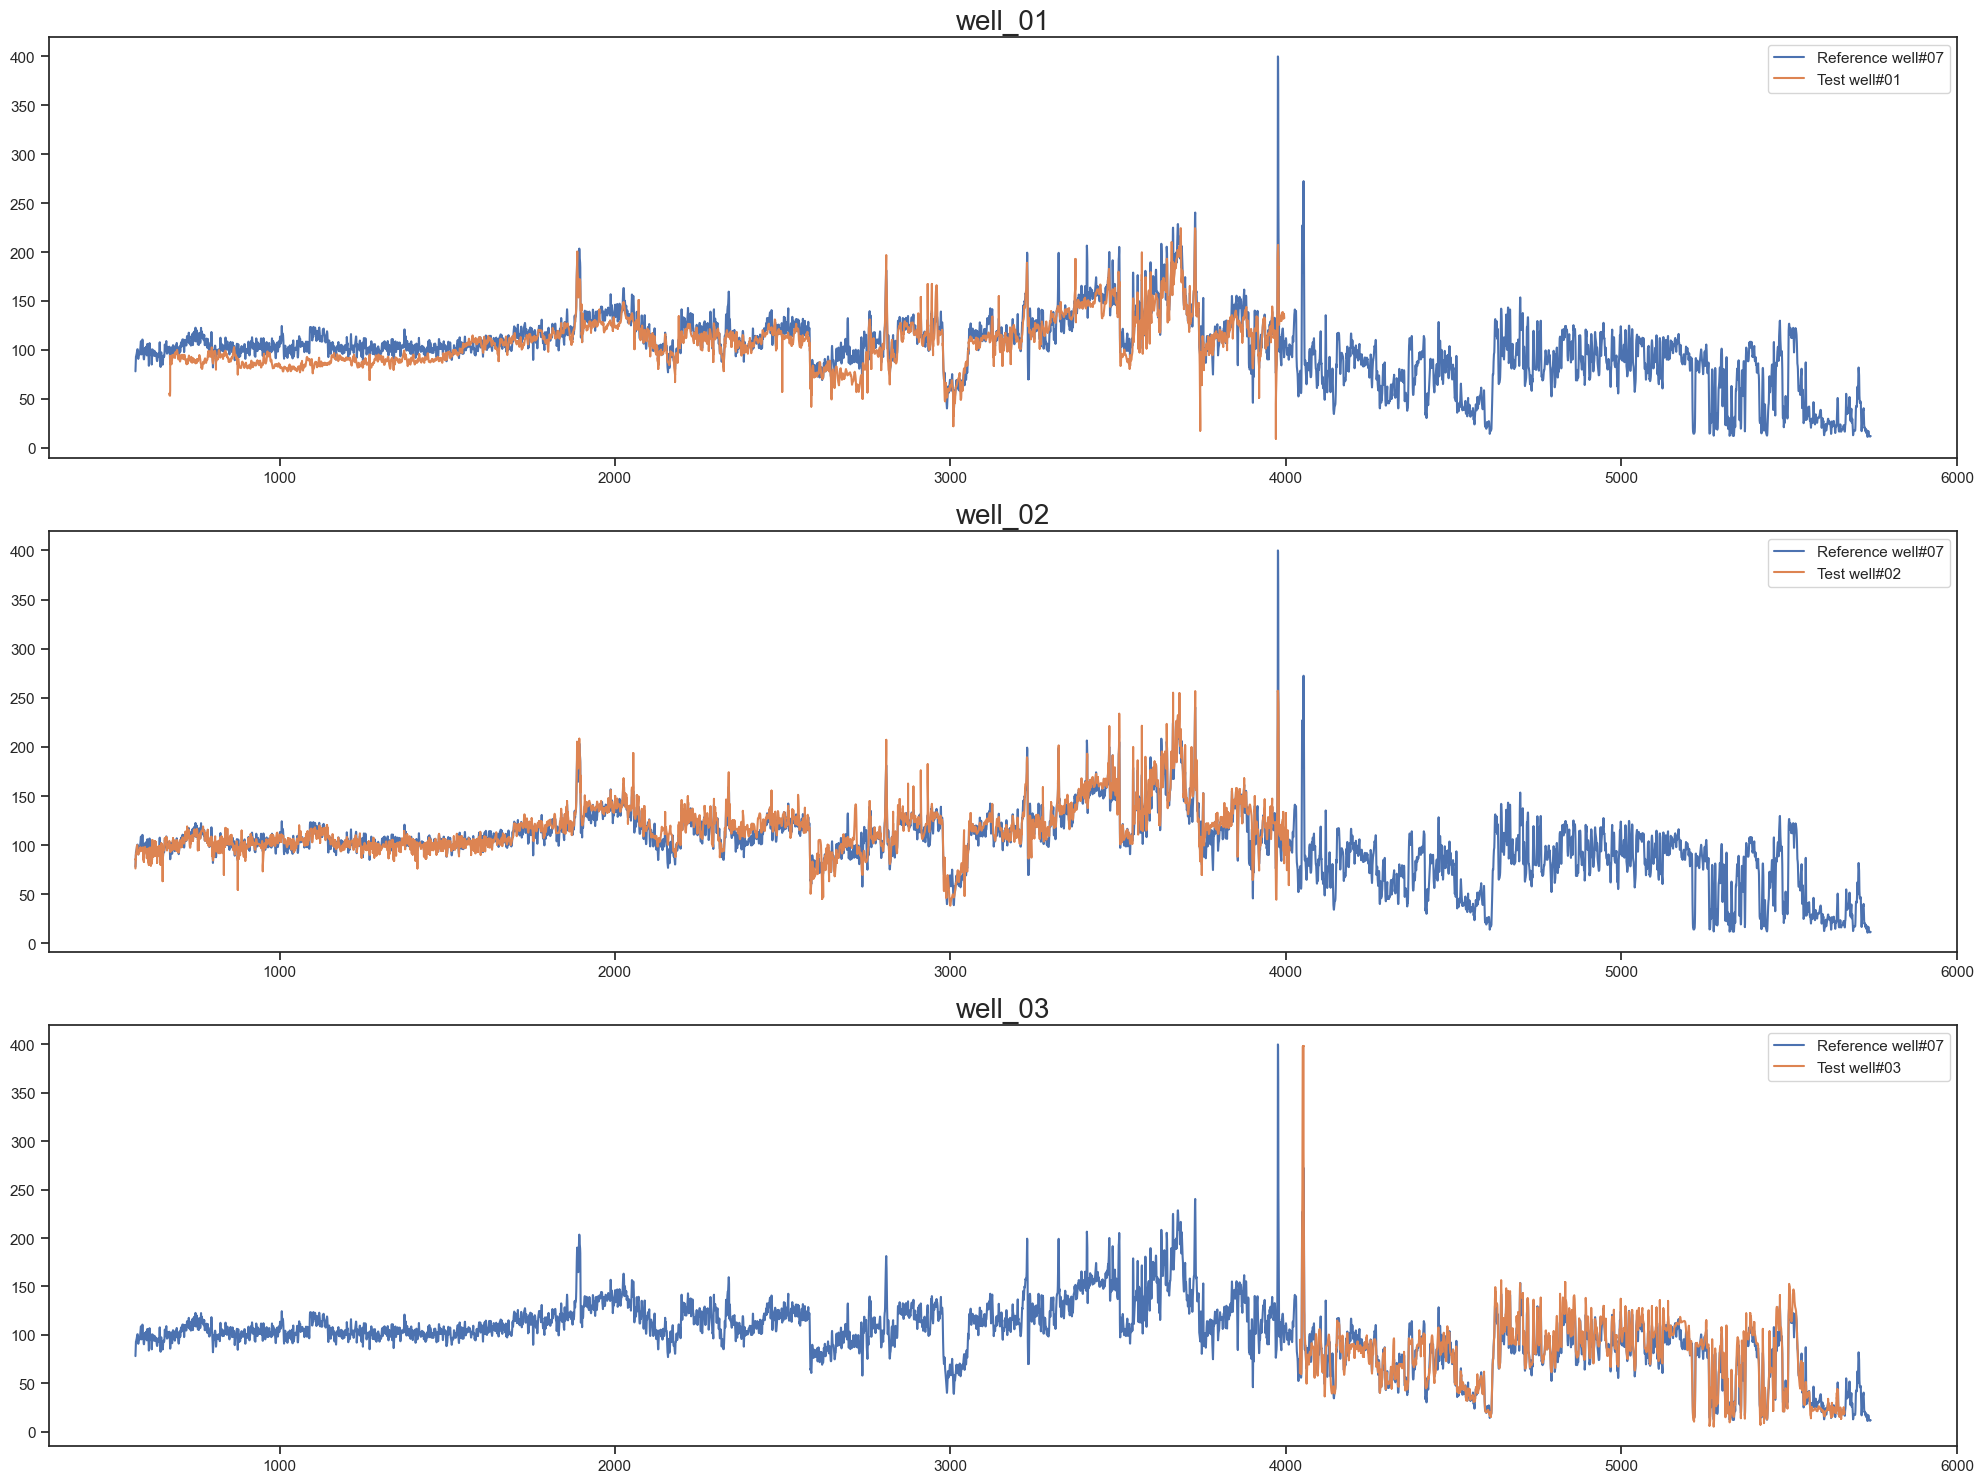

In [26]:
# 테스트 웰별 Pseudo-TVD 결과 플랏 비교
# Plot the re

well_num = ['01', '02', '03']

plt.figure(figsize=(20,15))
for _, i in enumerate(well_num):
    plt.subplot(3, 1, _+1)
    plt.plot(per_well[6]['Pseudo_TVD'], per_well[6]['GR'], label='Reference well#07')
    plt.plot(test_per_well[_]['Pseudo_TVD'], test_per_well[_]['GR'], label=f'Test well#{i}')
    plt.title(f'well_{i}', size=20)
    plt.legend()
plt.tight_layout()

### <a>5.3. Test data prediction</a>

In [27]:
# Predict the test log data ('NPHI', 'log_RD', 'RHOB) using the random forest model
test_well = test_per_well2[['Pseudo_TVD', 'GR', 'Zone', 'well']].copy()

test_well['Pseudo_TVD'] = scaler1.transform(np.asarray(test_well['Pseudo_TVD']).reshape(-1,1))
test_well['GR'] = scaler2.transform(np.asarray(test_well['GR']).reshape(-1,1))

test_well['Zone'] = test_well['Zone'].astype(int)

for zone in test_well['Zone'].unique():
    if zone in zone_mapping:
        zone_index = zone_mapping[zone]
        test_samples = test_well.loc[test_well['Zone'] == zone, ['Pseudo_TVD', 'GR']]
        if len(test_samples) > 0:
            x_feat1 = ['Pseudo_TVD', 'GR']
            x_feat2 = ['Pseudo_TVD', 'GR', 'NPHI']
            x_feat3 = ['Pseudo_TVD', 'GR', 'NPHI', 'log_RD']
            
            # Predict NPHI
            test_well.loc[test_well['Zone'] == zone, 'NPHI'] = models[zone_index][0].predict(test_samples[x_feat1])
            
            # Predict RHOB
            test_samples['NPHI'] = test_well.loc[test_well['Zone'] == zone, 'NPHI']
            test_well.loc[test_well['Zone'] == zone, 'log_RD'] = models[zone_index][1].predict(test_samples[x_feat2])
            
            # Predict log_RD
            test_samples['log_RD'] = test_well.loc[test_well['Zone'] == zone, 'log_RD']
            test_well.loc[test_well['Zone'] == zone, 'RHOB'] = models[zone_index][2].predict(test_samples[x_feat3])


test_well['NPHI'] = scaler3.inverse_transform(np.asarray(test_well['NPHI']).reshape(-1, 1))
test_well['RHOB'] = scaler4.inverse_transform(np.asarray(test_well['RHOB']).reshape(-1,1))
test_well['log_RD'] = scaler5.inverse_transform(np.asarray(test_well['log_RD']).reshape(-1,1))

test_well['RD'] = 10 ** test_well['log_RD']

test_per_well2['NPHI_pred'] = test_well['NPHI'].copy()
test_per_well2['RHOB_pred'] = test_well['RHOB'].copy()
test_per_well2['RD_pred'] = 10 ** test_well['log_RD'].copy()

### <a>5.4. Test data depth shifting</a>

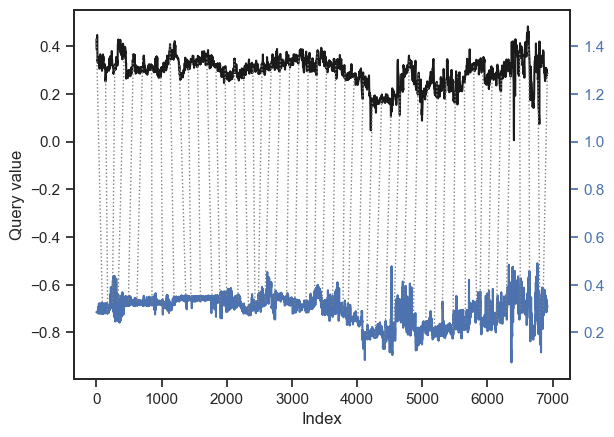

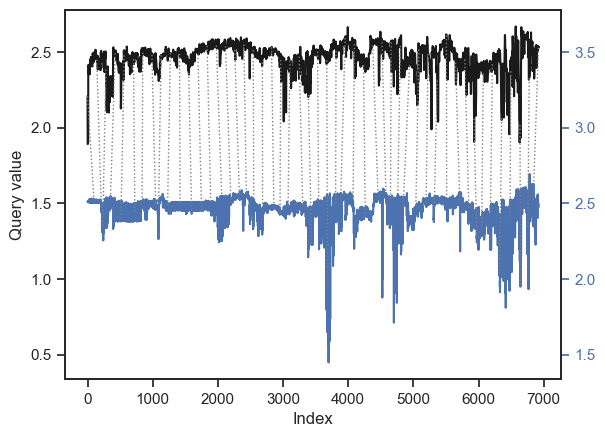

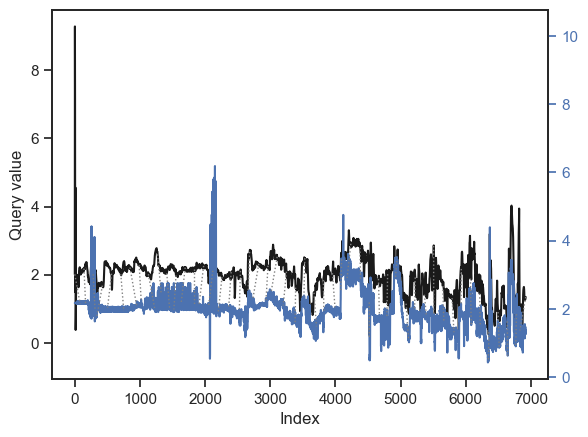

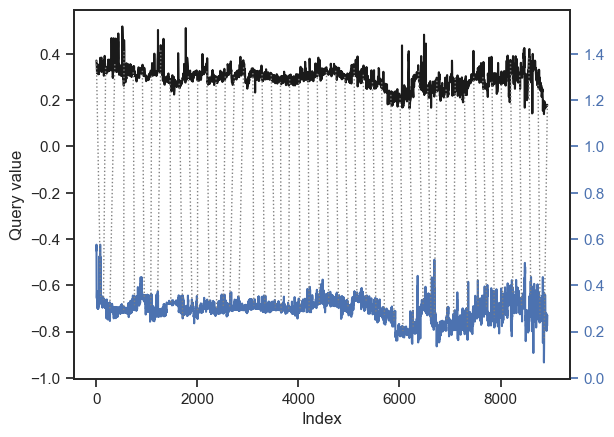

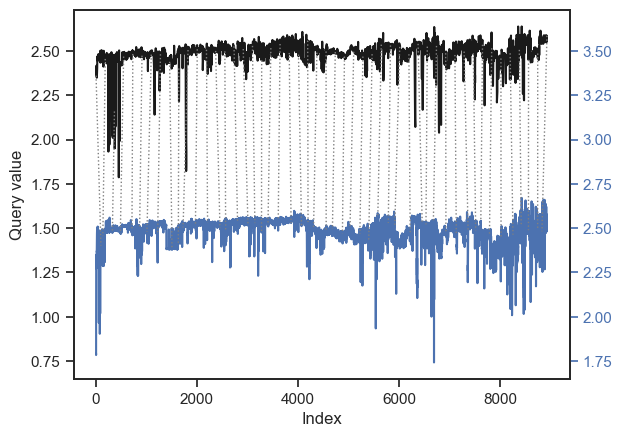

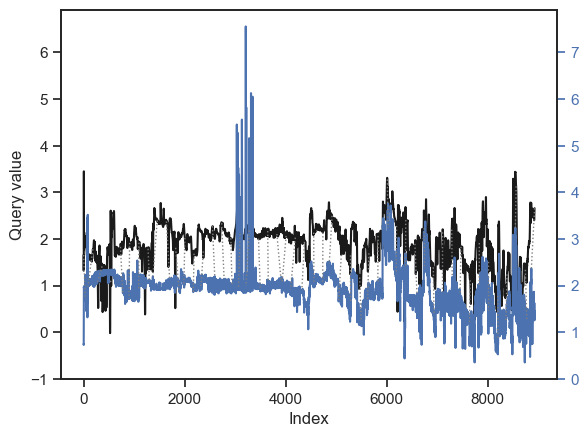

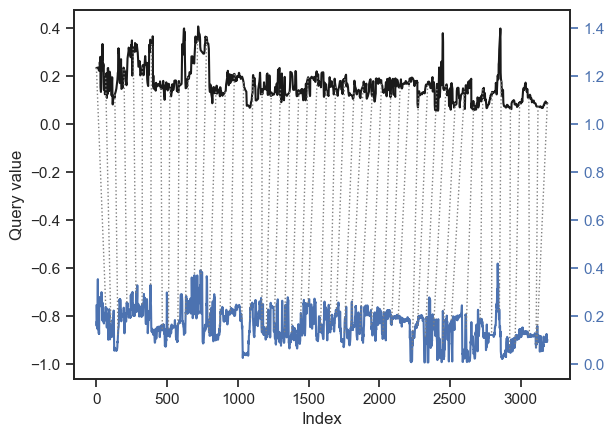

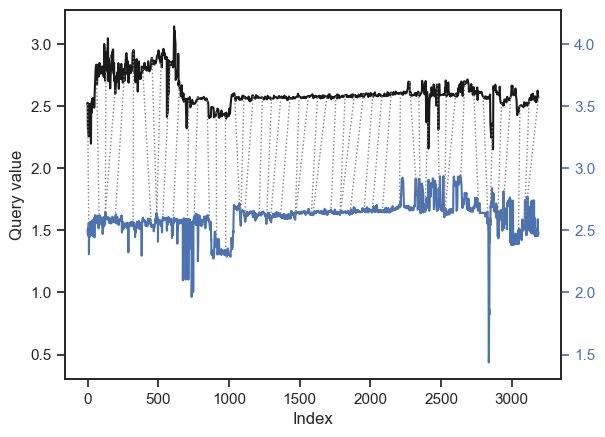

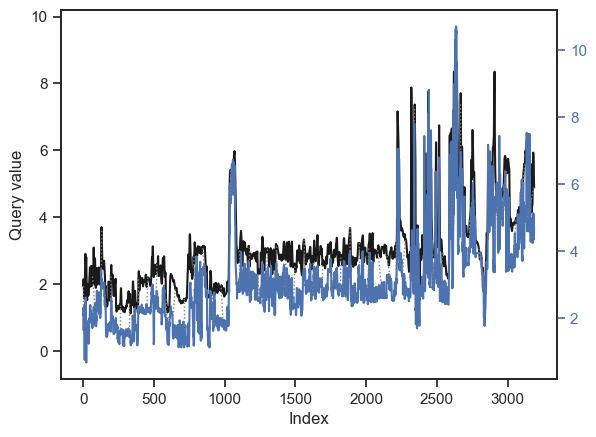

In [28]:
# apply the DTW algorithm to the misaligned log data using the predicted log data as the reference log data

Y_feat = ['NPHI', 'RHOB', 'RD']

for well in test_per_well2['well'].unique():
    test_per_well2['log_RD'] = np.log(test_per_well2.loc[test_per_well2['well']==well , 'RD'])
    test_per_well2['log_RD_pred'] = np.log(test_per_well2.loc[test_per_well2['well']==well, 'RD_pred'])
    for mykey in Y_feat:
        if mykey == 'RD':
            ref=test_per_well2.loc[test_per_well2['well']==well, 'log_RD_pred'].values
            query=test_per_well2.loc[test_per_well2['well']==well , 'log_RD'].values
                                 
            query=(query-query.mean())/query.std()*ref.std()+ref.mean()
            
            alignment = dt.dtw(query, ref, step_pattern='asymmetric', window_type='sakoechiba', keep_internals=True, open_end=True, open_begin=True, window_args={'window_size':100})
        elif mykey == 'RHOB':
            ref=test_per_well2.loc[test_per_well2['well']==well, 'RHOB_pred'].values
            query=test_per_well2.loc[test_per_well2['well']==well , 'RHOB'].values
                                 
            query=(query-query.mean())/query.std()*ref.std()+ref.mean()

            alignment = dt.dtw(query, ref, step_pattern='asymmetric', window_type='sakoechiba', keep_internals=True, open_end=True, open_begin=True, window_args={'window_size':100})
        else:
            ref=test_per_well2.loc[test_per_well2['well']==well, f'{mykey}_pred'].values
            query=test_per_well2.loc[test_per_well2['well']==well ,f'{mykey}'].values
                                 
            query=(query-query.mean())/query.std()*ref.std()+ref.mean()

            alignment = dt.dtw(query, ref, step_pattern='asymmetric', window_type='sakoechiba', keep_internals=True, open_end=True, open_begin=True, window_args={'window_size':100})
        alignment.plot(type='twoway', offset=-1)
        mypath = alignment.index2

        mypath=[0] + mypath

        test_per_well2.loc[test_per_well2['well']==well,f'{mykey}_dept_pred']=test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values[mypath]

        f=interpolate.interp1d(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values[mypath]+0.0000001*np.arange(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values.size),test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values,
                            fill_value=(test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values[0], test_per_well2.loc[test_per_well2['well']==well,f'{mykey}'].values[-1]), 
                            bounds_error=False,kind=1)
        test_per_well2.loc[test_per_well2['well']==well,f'{mykey}_pred']=f(test_per_well2.loc[test_per_well2['well']==well,'DEPT'].values)

In [29]:
# Extract test prediction data to excel
for well in test_per_well2['well'].unique():
    test_per_well2.loc[test_per_well2['well']==well].to_excel('{}.xlsx'.format(well))

## <a>6. Discussion</a>

There are several considerations for further study such as;

    1. Determination of designated criterion of zonation based on rock facies, using GR logs.
    2. Investigate other methods to mitigate RHOB prediction accracy dispersion including #1.

## <a>7. Summary</a>

 We divided rock facies for each well log data based on GR logs qualitatively in order to let the prediction model predict with each rock facies that may have different RHOB, NPHI and RD trend. Geological and petrophysical basis was repeatedly used with machine learning technique, which helped us to yield better performances at each trial.

## References
Yu, Y., Xu, C., Misra, S., Li, W., Ashby, M., Pan, W., Deng, T., Jo, H., Santos, J.E., Fu, L. and Wang, C., 2021, Synthetic Sonic Log Generation With Machine Learning: A Contest Summary From Five Methods, Petrophysics, 62(4), 393–406.